In [25]:
import cv2
import os
import pandas as pd
import numpy as np
from scipy.ndimage import label
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from scipy.ndimage import grey_opening,grey_closing

In [26]:
lyt = f'Z:/Gaochao/WBI/zexi/1219/1219-06/calcium_intensity.npy'
calcium_intensity= np.load(lyt)
save_p = lyt.split('calcium_intensity.npy')[0]
print(save_p)
print(calcium_intensity.shape)

Z:/Gaochao/WBI/zexi/1219/1219-06/
(89, 1464)


In [27]:
# 预处理
scale = 1.5
for i in range(calcium_intensity.shape[0]):
    calcium_intensity[i] = (cv2.blur(calcium_intensity[i], (1, 7))*scale)[:,0]

In [28]:
# 导入分析后的行为数据
beh_label = r'Z:\data space+\C. elegans chemotaxis\20241223_WBI\121906_position_als.csv'
df_pos_als = pd.read_csv(beh_label)

In [29]:
# 导入神经数据时间戳
neuron_time_label = r'Z:\data space+\C. elegans chemotaxis\20241223_WBI\121906__volume_timestamp.csv'
df_n_t = pd.read_csv(neuron_time_label)

In [30]:
# PCA
cov = np.cov(calcium_intensity)
ev,evec = np.linalg.eig(cov)
sort_idx=np.argsort(ev)[::-1]
ev=ev[sort_idx]
evec=evec[:,sort_idx]
expr = np.sum(ev[:2])/np.sum(ev)
xn= calcium_intensity.T @ evec.real

In [31]:
# 创建列名
column_names = [f"PC{i+1}" for i in range(xn.shape[1])]
# 转为 DataFrame
df_n = pd.DataFrame(xn, columns=column_names)

In [35]:
df_n['Vol_time'] = df_n_t.Vol_Time

In [36]:
df_nt = df_n.copy()
df_pos = df_pos_als.copy()
# 查找最近值和索引
nearest_times = []
nearest_indices = []

for vol_time in df_nt['Vol_time']:
    # 计算时间差的绝对值
    differences = np.abs(df_pos['Time'] - vol_time)
    # 找到最小差值的索引
    nearest_idx = np.argmin(differences)
    # 保存最近时间值和索引
    nearest_times.append(df_pos.loc[nearest_idx, 'Time'])
    nearest_indices.append(nearest_idx)

# 将结果存入 DataFrame
df_nt['Nearest_Time'] = nearest_times
df_nt['Nearest_Index'] = nearest_indices

In [37]:
df_nt

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0    -1.628836  1.184660  0.281963 -1.000053 -0.299896  0.009811 -0.832483   
1    -1.589842  1.147384  0.292264 -0.933332 -0.275267  0.015642 -0.796394   
2    -1.537229  1.098180  0.287488 -0.867103 -0.298038  0.037275 -0.720029   
3    -1.589886  1.069797  0.275041 -0.847134 -0.286452  0.043039 -0.682798   
4    -1.636900  1.025799  0.239687 -0.848707 -0.287842  0.020753 -0.681056   
...        ...       ...       ...       ...       ...       ...       ...   
1459 -1.201586  2.828331 -0.858387  0.608189  0.198501  1.105586 -0.553086   
1460 -1.277224  2.964308 -0.898001  0.620968  0.186458  1.187556 -0.561847   
1461 -1.306904  3.003079 -0.900869  0.579896  0.154432  1.190494 -0.588835   
1462 -1.317406  3.027171 -0.906566  0.521152  0.144920  1.165889 -0.599084   
1463 -1.327909  3.051264 -0.912263  0.462408  0.135409  1.141283 -0.609333   

           PC8       PC9      PC10  ...      PC83      PC84      PC85  \
0     0.406041 -0.140638  0.084367  ...  0.033600  0.061626  0.033517   
1     0.429188 -0.162245  0.092627  ...  0.041821  0.061357  0.015691   
2     0.441587 -0.132636  0.090009  ...  0.007544  0.080080  0.034842   
3     0.385401 -0.144312  0.071437  ...  0.048390  0.110463  0.028380   
4     0.389994 -0.129557  0.078721  ...  0.016542  0.080853  0.050477   
...        ...       ...       ...  ...       ...       ...       ...   
1459 -0.185126 -0.085543  0.565788  ...  0.029435  0.084837  0.043239   
1460 -0.174559 -0.100502  0.603196  ...  0.027042  0.110138  0.040332   
1461 -0.162125 -0.122900  0.594949  ...  0.033944  0.108076  0.031214   
1462 -0.166565 -0.131104  0.608842  ...  0.038937  0.106603  0.023193   
1463 -0.171004 -0.139308  0.622735  ...  0.043930  0.105131  0.015171   

          PC86      PC87      PC88      PC89  Vol_time  Nearest_Time  \
0    -0.051605  0.051227  0.001418  0.071504    98.870        98.861   
1    -0.038245  0.026465  0.011324  0.035461    99.170        99.183   
2    -0.009304  0.032726 -0.008586  0.035383    99.470        99.475   
3    -0.012299  0.016595 -0.012894  0.034054    99.773        99.771   
4    -0.007850  0.034826 -0.016493  0.024926   100.072       100.065   
...        ...       ...       ...       ...       ...           ...   
1459 -0.027947 -0.005354 -0.009123  0.019075   536.582       536.581   
1460 -0.035662 -0.007481 -0.018548  0.037491   536.881       536.877   
1461 -0.015663  0.003210 -0.022412  0.033543   537.180       537.171   
1462  0.007943  0.004998 -0.022019  0.028567   537.479       537.467   
1463  0.031549  0.006787 -0.021625  0.023590   537.778       537.787   

      Nearest_Index  
0                 0  
1                12  
2                23  
3                34  
4                45  
...             ...  
1459          16373  
1460          16384  
1461          16395  
1462          16406  
1463          16418  

[1464 rows x 92 columns]

In [38]:
# 从df_pos中赋值列到df_nt
columns_to_add = ['X', 'Y', 'speed', 'agl_speed', 'CTX_left', 'Event', 'Reorientation']
for col in columns_to_add:
    df_nt[col] = df_nt['Nearest_Index'].map(df_pos_als[col])

In [39]:
# 重置X轴坐标值
df_nt_mx = df_nt.copy()
df_nt_mx['X'] = df_nt['X']-df_nt['X'].min()

In [40]:
df_nt_mx

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0    -1.628836  1.184660  0.281963 -1.000053 -0.299896  0.009811 -0.832483   
1    -1.589842  1.147384  0.292264 -0.933332 -0.275267  0.015642 -0.796394   
2    -1.537229  1.098180  0.287488 -0.867103 -0.298038  0.037275 -0.720029   
3    -1.589886  1.069797  0.275041 -0.847134 -0.286452  0.043039 -0.682798   
4    -1.636900  1.025799  0.239687 -0.848707 -0.287842  0.020753 -0.681056   
...        ...       ...       ...       ...       ...       ...       ...   
1459 -1.201586  2.828331 -0.858387  0.608189  0.198501  1.105586 -0.553086   
1460 -1.277224  2.964308 -0.898001  0.620968  0.186458  1.187556 -0.561847   
1461 -1.306904  3.003079 -0.900869  0.579896  0.154432  1.190494 -0.588835   
1462 -1.317406  3.027171 -0.906566  0.521152  0.144920  1.165889 -0.599084   
1463 -1.327909  3.051264 -0.912263  0.462408  0.135409  1.141283 -0.609333   

           PC8       PC9      PC10  ...  Vol_time  Nearest_Time  \
0     0.406041 -0.140638  0.084367  ...    98.870        98.861   
1     0.429188 -0.162245  0.092627  ...    99.170        99.183   
2     0.441587 -0.132636  0.090009  ...    99.470        99.475   
3     0.385401 -0.144312  0.071437  ...    99.773        99.771   
4     0.389994 -0.129557  0.078721  ...   100.072       100.065   
...        ...       ...       ...  ...       ...           ...   
1459 -0.185126 -0.085543  0.565788  ...   536.582       536.581   
1460 -0.174559 -0.100502  0.603196  ...   536.881       536.877   
1461 -0.162125 -0.122900  0.594949  ...   537.180       537.171   
1462 -0.166565 -0.131104  0.608842  ...   537.479       537.467   
1463 -0.171004 -0.139308  0.622735  ...   537.778       537.787   

      Nearest_Index          X          Y  speed  agl_speed  CTX_left  Event  \
0                 0        NaN        NaN    NaN        NaN       NaN      0   
1                12        NaN        NaN    NaN        NaN       NaN      0   
2                23        NaN        NaN    NaN        NaN       NaN      0   
3                34        NaN        NaN    NaN        NaN       NaN      0   
4                45        NaN        NaN    NaN        0.0       NaN      0   
...             ...        ...        ...    ...        ...       ...    ...   
1459          16373  16.626337  25.972573    NaN        0.0       NaN      0   
1460          16384        NaN        NaN    NaN        0.0       NaN      0   
1461          16395        NaN        NaN    NaN        NaN       NaN      0   
1462          16406        NaN        NaN    NaN        NaN       NaN      0   
1463          16418        NaN        NaN    NaN        NaN       NaN      0   

      Reorientation  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
...             ...  
1459              0  
1460              0  
1461              0  
1462              0  
1463              0  

[1464 rows x 99 columns]

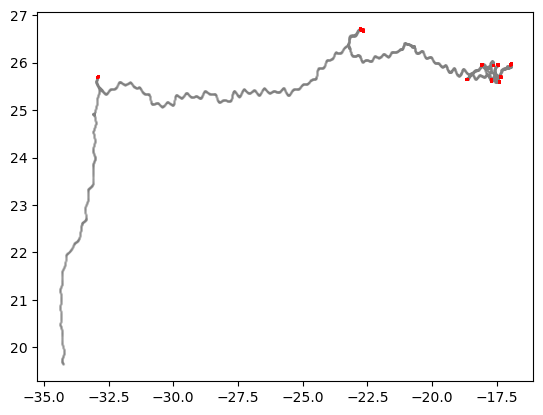

In [42]:
plt.scatter(df_pos_als['X'], df_pos_als['Y'],s=0.8, c='grey', alpha=0.05)
df_pos_t = df_pos_als[df_pos_als.Reorientation==1]
plt.scatter(df_pos_t['X'], df_pos_t['Y'],s=1, c='r')
plt.show()

In [71]:
# 移动平均窗口大小
window_size = 10
# 计算移动平均值
df_nt_mx['smoothed_speed'] = df_nt_mx['speed'].rolling(window=window_size, min_periods=1).mean()
# 将每个窗口的平均值赋给第一个值
df_nt_mx['adjusted_speed'] = df_nt_mx['smoothed_speed'].shift(-(window_size - 1))
# 用第一个值填充原窗口范围
for i in range(len(df_nt_mx) - window_size + 1):
    df_nt_mx.loc[i:i + window_size - 1, 'adjusted_speed'] = df_nt_mx.loc[i, 'adjusted_speed']
# 确保未被覆盖的行填充为NaN
df_nt_mx['adjusted_speed'] = df_nt_mx['adjusted_speed'].fillna(df_nt_mx['speed'])

In [66]:
# 平滑角速度
window_size = 30
# 计算移动平均值
df_nt_mx['smoothed_ctx'] = df_nt_mx['CTX_left'].rolling(window=window_size, min_periods=1).mean()

In [76]:
# 平滑角速度
window_size = 20
# 计算移动平均值
df_nt_mx['smoothed_PC2'] = df_nt_mx['PC2'].rolling(window=window_size, min_periods=1).mean()

In [68]:
# 移动平均窗口大小
window_size = 30
# 计算移动平均值
df_nt_mx['smoothed_agl'] = df_nt_mx['agl_speed'].rolling(window=window_size, min_periods=1).mean()
# 将每个窗口的平均值赋给第一个值
df_nt_mx['adjusted_agl'] = df_nt_mx['smoothed_agl'].shift(-(window_size - 1))
# 用第一个值填充原窗口范围
for i in range(len(df_nt_mx) - window_size + 1):
    df_nt_mx.loc[i:i + window_size - 1, 'adjusted_agl'] = df_nt_mx.loc[i, 'adjusted_agl']
# 确保未被覆盖的行填充为NaN
df_nt_mx['adjusted_agl'] = df_nt_mx['adjusted_agl'].fillna(df_nt_mx['agl_speed'])

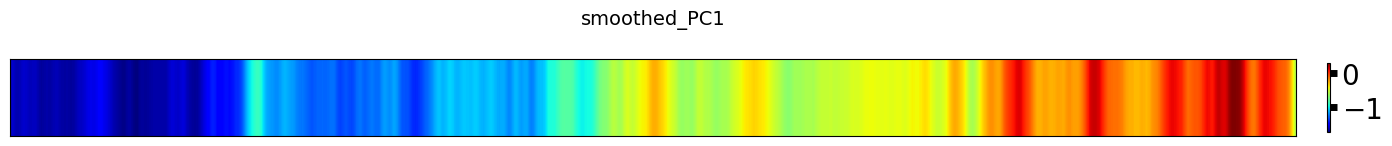

In [79]:
# 画任意col的一维热图
col='smoothed_PC1'
vector = df_nt_mx[col].values
heatmap_data = vector[np.newaxis, :]  # 变为 1 行 N 列

# 绘制热图
fig, ax = plt.subplots(figsize=(20, 1))  # 设置热图大小
im = ax.imshow(heatmap_data, cmap='jet', aspect='auto')  # 绘制热图

# 调整 colorbar 参数
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.9, aspect=30, pad=0.02)
cbar.set_label('', fontsize=20)  # 设置颜色条标签
cbar.ax.tick_params(labelsize=20, width=5, length=5)  # 设置刻度大小和宽度

# 设置标题和轴
ax.set_xticks([])  # 隐藏x轴刻度
ax.set_yticks([])  # 隐藏y轴刻度
ax.set_title(col, pad=25, fontsize=14)  # 设置标题

plt.show()

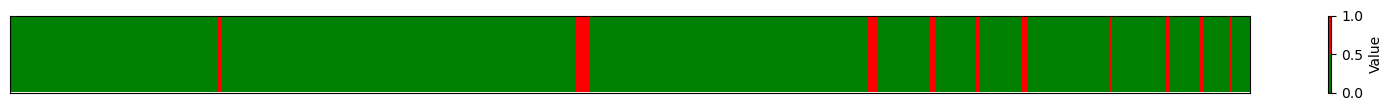

In [45]:


# 示例一维向量
vector = df_nt.Reorientation.values

# 将一维向量扩展为二维（例如 1 行或 1 列）
heatmap_data = vector[np.newaxis, :]  # 变为 1 行 N 列

# Define two colors
colors = ['green', 'red']

# Create a ListedColormap
two_color_cmap = ListedColormap(colors)

# 绘制热图
plt.figure(figsize=(20, 1))  # 设置热图大小
plt.imshow(heatmap_data, cmap=two_color_cmap, aspect='auto')  # 选择 colormap
plt.colorbar(label='Value')  # 添加颜色条
plt.xticks([])  # 设置x轴刻度
plt.yticks([])  # 隐藏y轴刻度
# plt.title("Heatmap of 1D Vector")
plt.show()

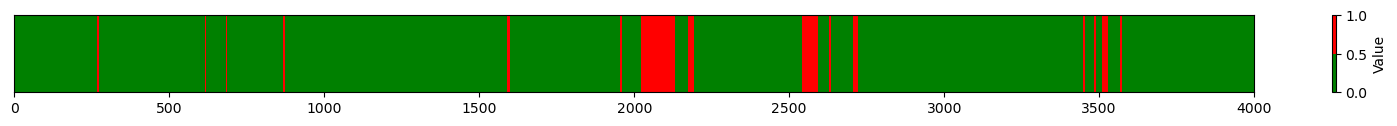

In [33]:
# 合并小的reorientation

# Define the size of the structuring element
structure_size = 5

# Perform opening
opened_vector = grey_opening(heatmap_data, size=structure_size)

structure_size = 13
# Perform closing
opened_vector = grey_closing(opened_vector, size=structure_size)

plt.figure(figsize=(20, 1))  # 设置热图大小
plt.imshow(opened_vector, cmap=two_color_cmap, aspect='auto')  # 选择 colormap
plt.colorbar(label='Value')  # 添加颜色条
plt.xticks()  # 设置x轴刻度
plt.yticks([])  # 隐藏y轴刻度
# plt.title("Heatmap of 1D Vector")
plt.show()

In [47]:

# 找到Reorientation分隔的起始点
vector = vector

start_indices = np.where(np.diff(np.insert(vector, 0, 0)) == 1)[0]
end_indices = np.where(np.diff(np.append(vector, 0)) == -1)[0]

In [35]:
start_idx_all = np.where(np.diff(np.insert(heatmap_data, 0, 0)) == 1)[0]

In [36]:
start_idx_all

array([   9,  180,  267,  615,  657,  682,  717,  783,  868,  911,  928,
       1049, 1062, 1514, 1591, 1652, 1680, 1697, 1786, 1870, 1955, 2020,
       2038, 2054, 2084, 2151, 2173, 2214, 2542, 2561, 2606, 2627, 2664,
       2706, 2823, 3446, 3481, 3508, 3567, 3749], dtype=int64)

In [48]:
start_indices

array([ 244,  668, 1012, 1085, 1139, 1194, 1296, 1364, 1404, 1438],
      dtype=int64)

In [49]:
end_indices

array([ 248,  683, 1022, 1090, 1143, 1199, 1298, 1368, 1407, 1439],
      dtype=int64)

C:\Users\Windows11\AppData\Local\Temp\ipykernel_12408\2645404390.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(df_nt_mx['PC1'], df_nt_mx['PC2'], c='grey',cmap='jet', s=0.8)


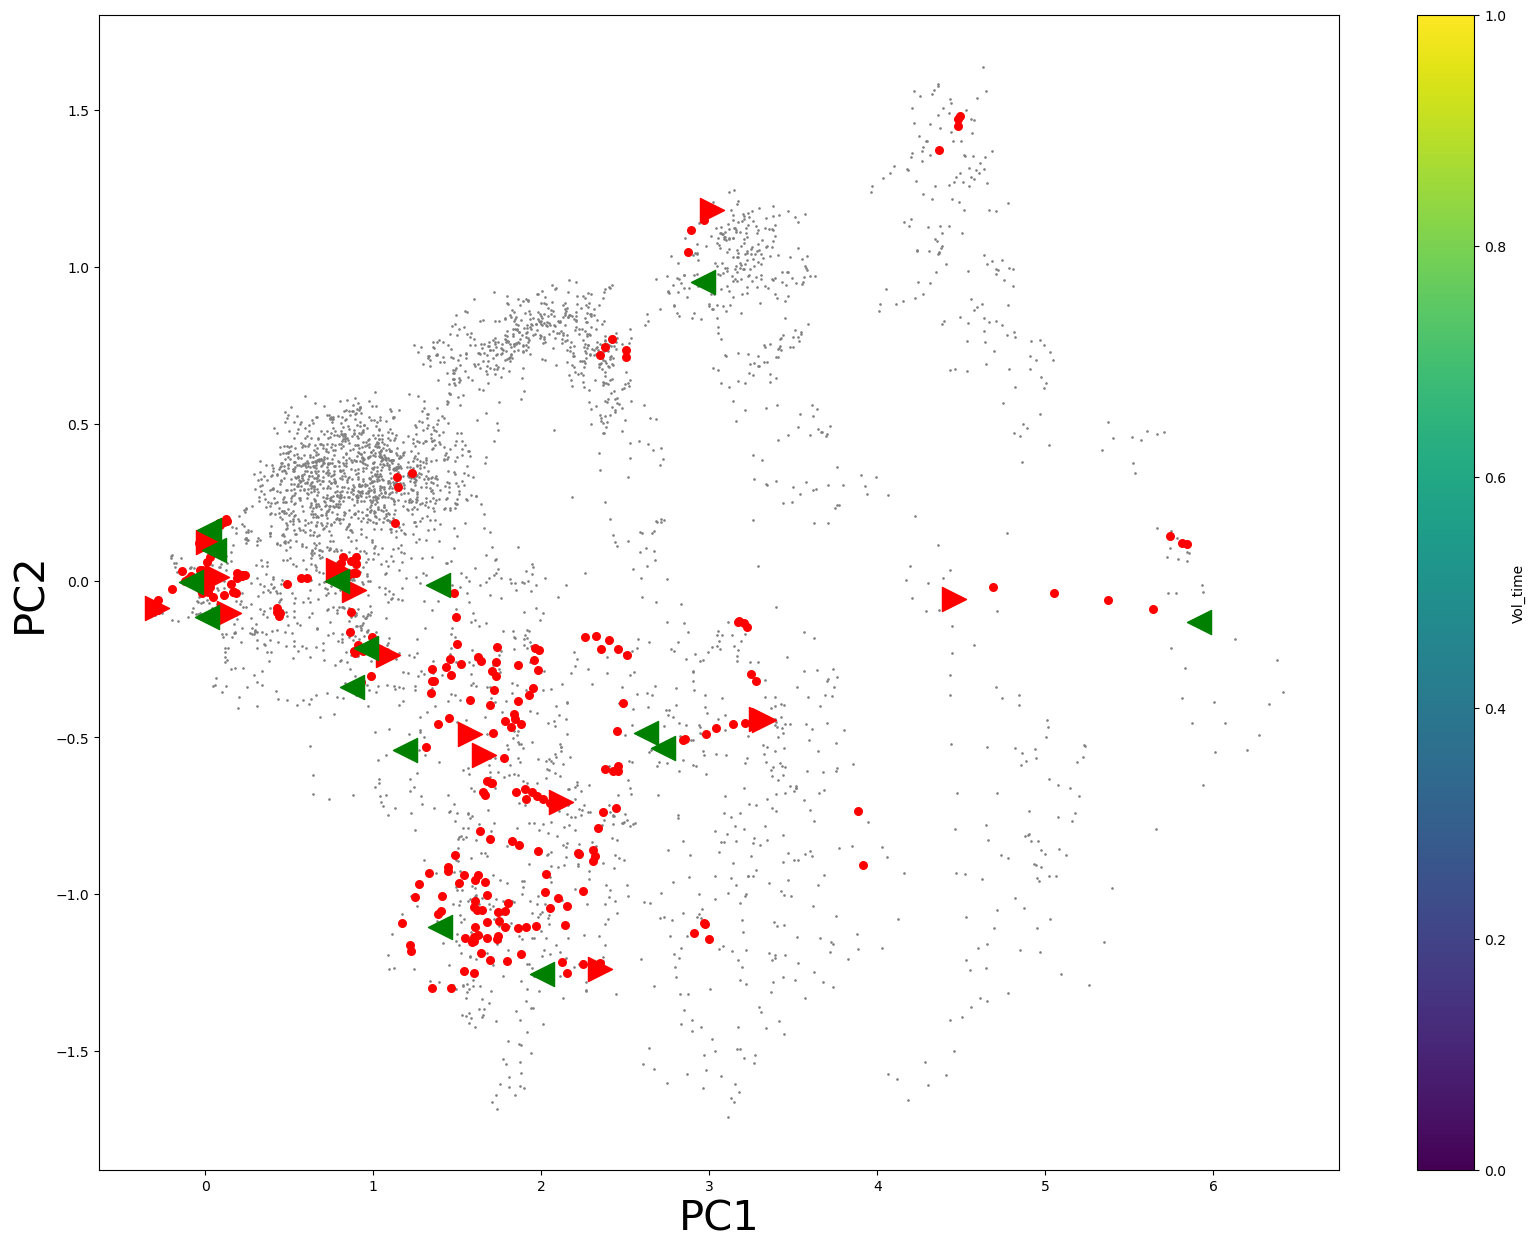

In [40]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable

fig, ax = plt.subplots(figsize = (20,15))
fs = 30
label = 'Vol_time'
# 绘制散点图，并返回散点图对象
sc = ax.scatter(df_nt_mx['PC1'], df_nt_mx['PC2'], c='grey',cmap='jet', s=0.8)


df_nt_reo = df_nt_mx[df_nt_mx.Reorientation==1]
plt.scatter(df_nt_reo['PC1'], df_nt_reo['PC2'], s=fs, c='r')
# ls_t_idx = list(df_nt_reo.index)
# str_t_ls_idx = list(map(str,ls_t_idx))
# for x, y, text in zip(df_nt_reo['PC2'], df_nt_reo['PC3'], str_t_ls_idx):
#     plt.text(x, y, text, color='k', fontsize=fs*0.35)  

df_nt_start = df_nt_mx.loc[start_indices]
df_nt_end = df_nt_mx.loc[end_indices]
ls_s_idx = list(df_nt_start.index)
str_s_ls_idx = list(map(str,ls_s_idx))
# for x, y, text in zip(df_nt_start['PC1'], df_nt_start['PC2'], str_s_ls_idx):
#     plt.text(x, y, text, color='r', fontsize=fs)

ls_e_idx = list(df_nt_end.index)
str_e_ls_idx = list(map(str,ls_e_idx))
# for x, y, text in zip(df_nt_end['PC1'], df_nt_end['PC2'], str_e_ls_idx):
#     plt.text(x, y, text, color='g', fontsize=fs)    

start = ax.scatter(df_nt_start['PC1'], df_nt_start['PC2'], s=fs*10, marker='>', c = 'r')
end = ax.scatter(df_nt_end['PC1'], df_nt_end['PC2'], s=fs*10, marker='<', c = 'g')
# sm = ScalarMappable(cmap=cmp, norm=plt.Normalize(vmin=df_nt.X.max(), vmax=df_nt.X.min()))
# sm.set_array([])  # 需要设置数组，即使它是空的

# 添加颜色条，并设置标签
plt.colorbar(sc, label=label)
plt.xlabel('PC1',fontsize=fs)
plt.ylabel('PC2',fontsize=fs)
plt.show()


C:\Users\Windows11\AppData\Local\Temp\ipykernel_28904\967743422.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(df_nt_mx['PC2'], df_nt_mx['PC3'], c='grey',cmap='jet', s=0.8)


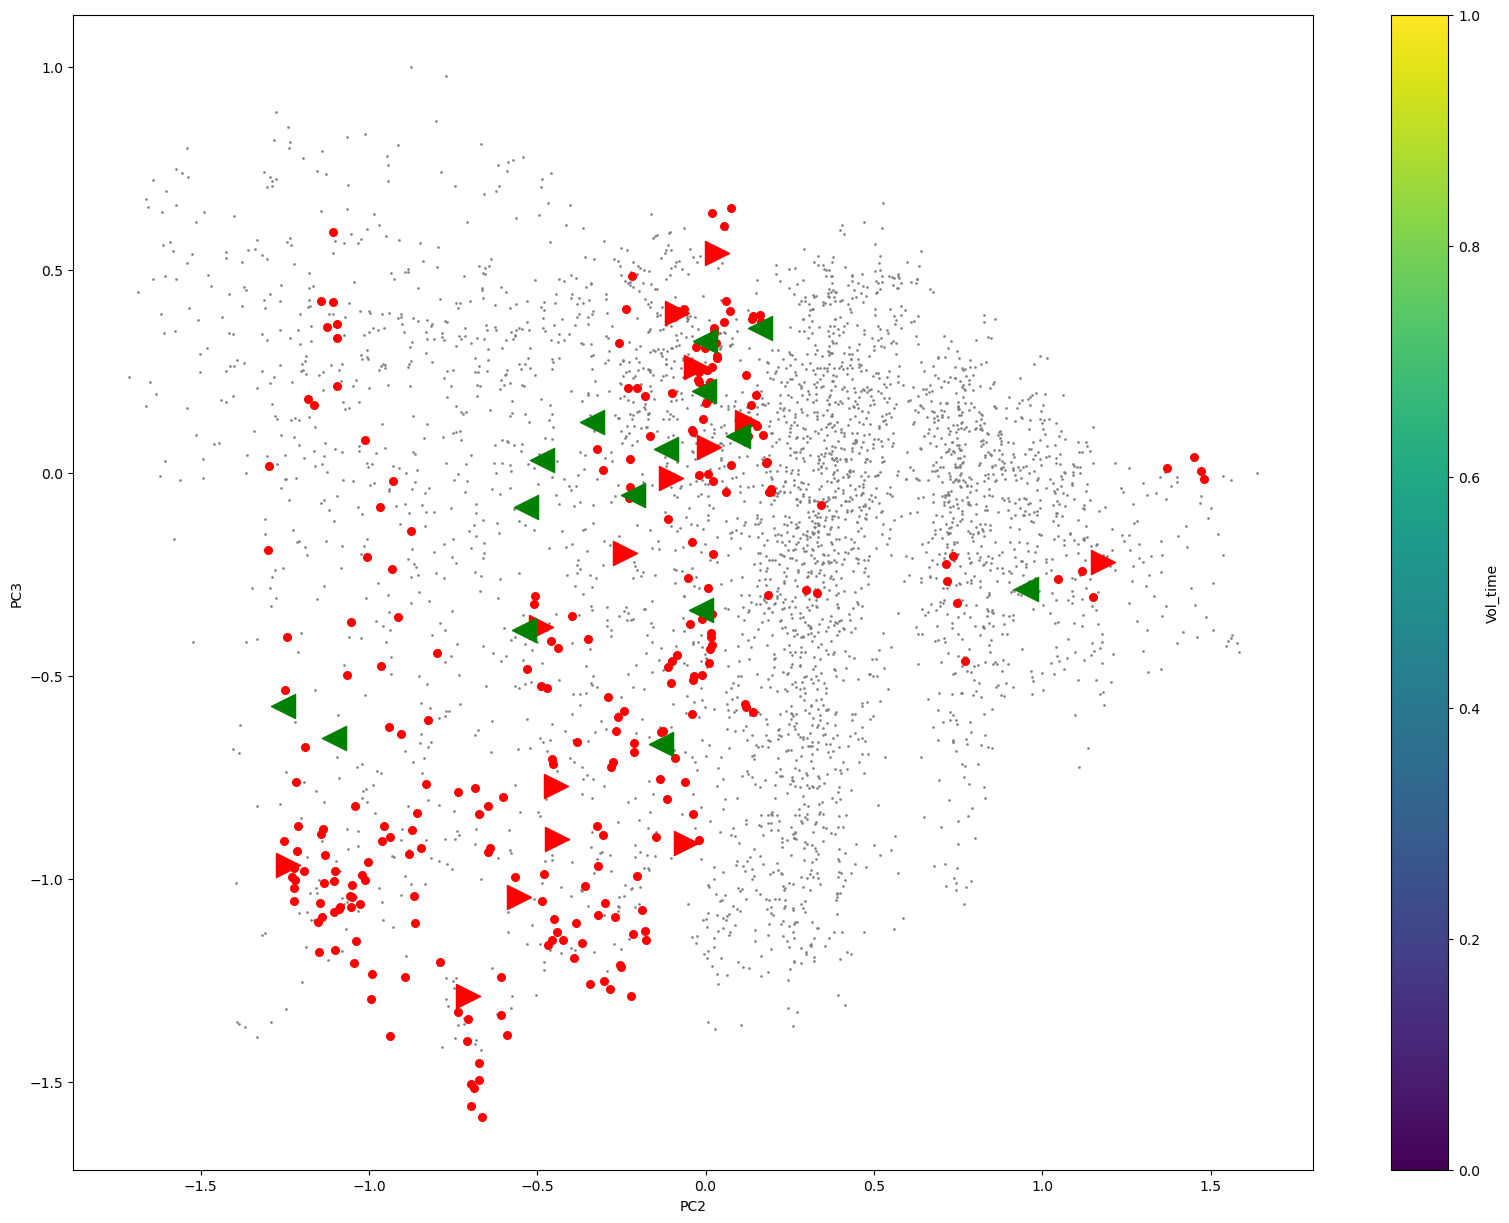

In [351]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable

fig, ax = plt.subplots(figsize = (20,15))
fs = 30
label = 'Vol_time'
# 绘制散点图，并返回散点图对象
sc = ax.scatter(df_nt_mx['PC2'], df_nt_mx['PC3'], c='grey',cmap='jet', s=0.8)


df_nt_reo = df_nt_mx[df_nt_mx.Reorientation==1]
plt.scatter(df_nt_reo['PC2'], df_nt_reo['PC3'], s=fs, c='r')
# ls_t_idx = list(df_nt_reo.index)
# str_t_ls_idx = list(map(str,ls_t_idx))
# for x, y, text in zip(df_nt_reo['PC2'], df_nt_reo['PC3'], str_t_ls_idx):
#     plt.text(x, y, text, color='k', fontsize=fs*0.35)  

df_nt_start = df_nt_mx.loc[start_indices]
df_nt_end = df_nt_mx.loc[end_indices]
ls_s_idx = list(df_nt_start.index)
str_s_ls_idx = list(map(str,ls_s_idx))
# for x, y, text in zip(df_nt_start['PC1'], df_nt_start['PC2'], str_s_ls_idx):
#     plt.text(x, y, text, color='r', fontsize=fs)

ls_e_idx = list(df_nt_end.index)
str_e_ls_idx = list(map(str,ls_e_idx))
# for x, y, text in zip(df_nt_end['PC1'], df_nt_end['PC2'], str_e_ls_idx):
#     plt.text(x, y, text, color='g', fontsize=fs)    

start = ax.scatter(df_nt_start['PC2'], df_nt_start['PC3'], s=fs*10, marker='>', c = 'r')
end = ax.scatter(df_nt_end['PC2'], df_nt_end['PC3'], s=fs*10, marker='<', c = 'g')
# sm = ScalarMappable(cmap=cmp, norm=plt.Normalize(vmin=df_nt.X.max(), vmax=df_nt.X.min()))
# sm.set_array([])  # 需要设置数组，即使它是空的

# 添加颜色条，并设置标签
plt.colorbar(sc, label=label)
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.show()


In [54]:
start_indices

array([ 244,  668, 1012, 1085, 1139, 1194, 1296, 1364, 1404, 1438],
      dtype=int64)

In [55]:
len(df_nt_mx)

1464

In [56]:
start_index_sel = [0, 244,  668, 1012, 1085, 1139, 1194, 1296, 1364, 1404, 1438, 1464]

C:\Users\Windows11\AppData\Local\Temp\ipykernel_22712\232278277.py:36: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  sc = ax.scatter(


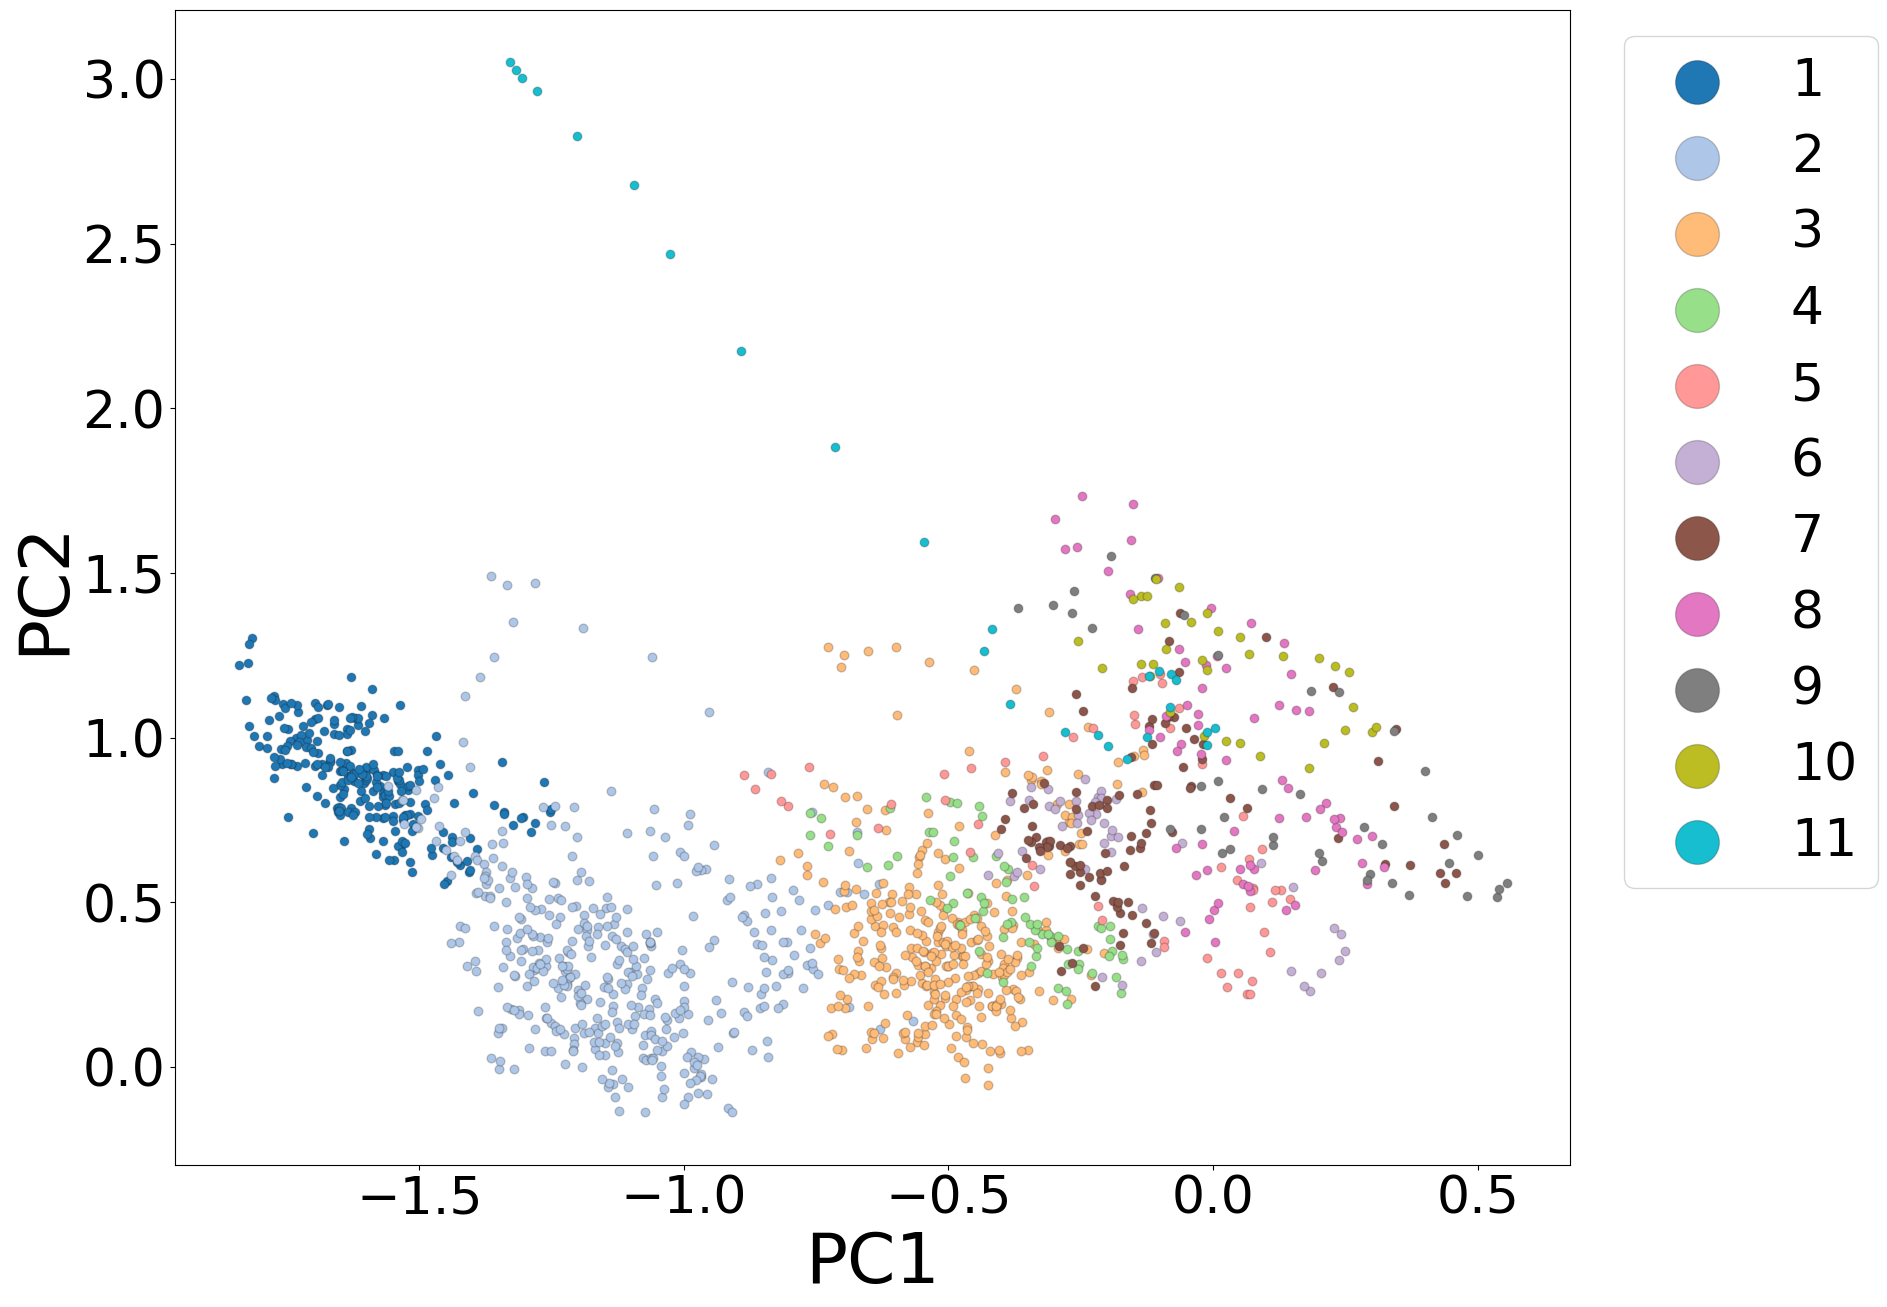

In [57]:
# 根据分隔索引对流形标记颜色
# 自定义分段间距(注意分隔加上首尾索引)
segment_boundaries = start_index_sel  # 分段区间
# colors = ['Blues', 'Reds', 'Greens', 'Oranges','Purples', 'GnBu','YlOrRd','YlGn']  # 每段对应的颜色映射
# colors = ['Blue', 'Yellow', 'Grees', 'Oranges','Red', 'Purple','YlOrRd','YlGn']
# colors = [
#     (1.0, 0.0, 0.0),  # 红色
#     (0.0, 1.0, 0.0),  # 绿色
#     (0.0, 0.0, 1.0),  # 蓝色
#     (1.0, 1.0, 0.0),  # 黄色
#     (1.0, 0.0, 1.0),  # 品红
#     (0.0, 1.0, 1.0),  # 青色
#     (0.5, 0.5, 0.5),  # 灰色
#     (1.0, 0.5, 0.0),  # 橙色
#     (0.5, 0.0, 1.0),  # 紫色
#     (0.0, 0.5, 0.5),  # 深青
# ]
colors = plt.cm.tab20(np.linspace(0, 1, len(start_index_sel)))[:, :3]  # 获取 RGB 值
colors_list = [tuple(color) for color in colors]

fig, ax = plt.subplots(figsize=(18, 15))
fs = 50
# 遍历分段
for i in range(len(segment_boundaries) - 1):
    start, end = segment_boundaries[i], segment_boundaries[i + 1]
    segment = df_nt_mx.iloc[start:end]

    # 创建渐变颜色映射
#     cmap = plt.get_cmap(colors[i])
#     norm = plt.Normalize(vmin=start, vmax=end)

        # 绘制散点图
    #     sc = ax.scatter(
    #         segment['PC1'], segment['PC2'], 
    #         c=segment.index, cmap=cmap, norm=norm, s=20, label=f'Segment {i + 1}'
    #     )
    sc = ax.scatter(
        segment['PC1'], segment['PC2'], 
        c=colors_list[i], s=40,edgecolors=((0,0,0,0.2)), label=f'{i + 1}'
    )

    # 添加颜色条
#     cbar = plt.colorbar(sc, ax=ax)
#     cbar.set_label(f'Segment {i + 1} Index')

# 添加图例和其他信息
ax.set_xlabel('PC1',fontsize = fs)
ax.set_ylabel('PC2',fontsize = fs)
ax.tick_params(labelsize = fs*0.75)
ax.legend(fontsize = fs*0.75, bbox_to_anchor = (1.02,1), markerscale=5)
plt.show()


C:\Users\Windows11\AppData\Local\Temp\ipykernel_22712\4233728169.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  sc = ax.scatter(


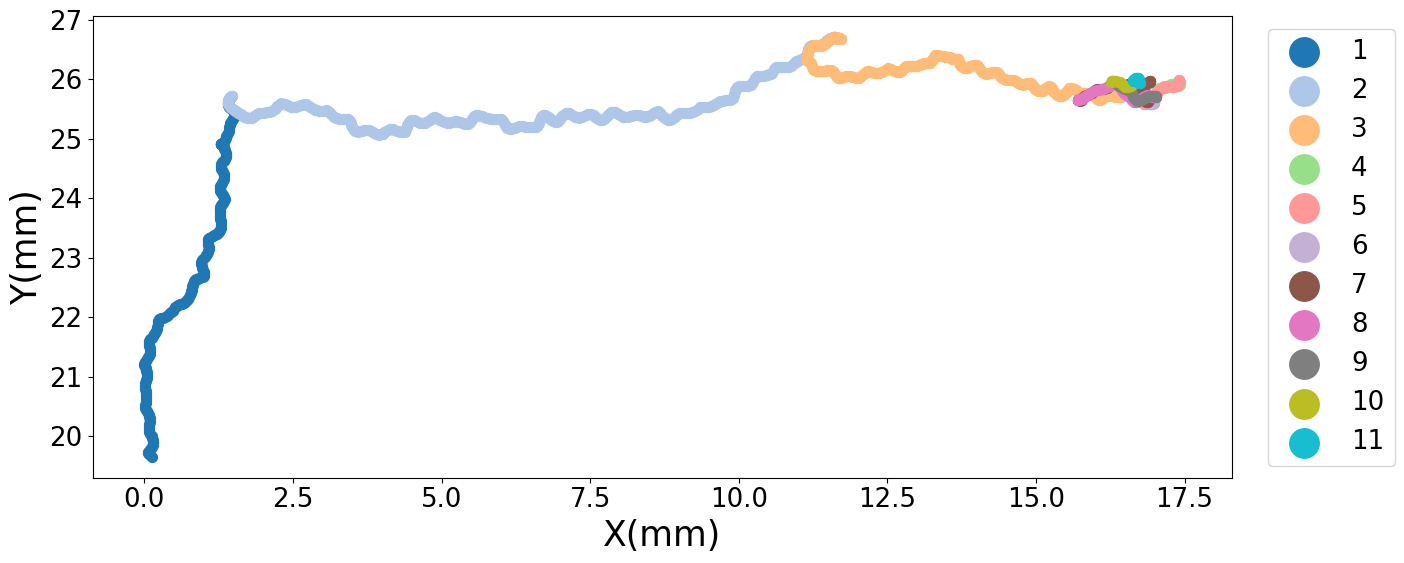

In [62]:
# 根据轨迹分隔索引画出分段轨迹
fig, ax = plt.subplots(figsize=(18, 6))
fs = 25
for i in range(len(segment_boundaries) - 1):
    start, end = segment_boundaries[i], segment_boundaries[i + 1]
    segment = df_nt_mx.iloc[start:end]
    sc = ax.scatter(
        segment['X'], segment['Y'], 
        c=colors_list[i], s=50, label=f'{i + 1}'
    )
ax.set_aspect(1)
ax.set_xlabel('X(mm)',fontsize = fs)
ax.set_ylabel('Y(mm)',fontsize = fs)
ax.tick_params(labelsize = fs*0.75)
ax.legend(fontsize = fs*0.75, bbox_to_anchor = (1.02,1), markerscale=3)
plt.show()

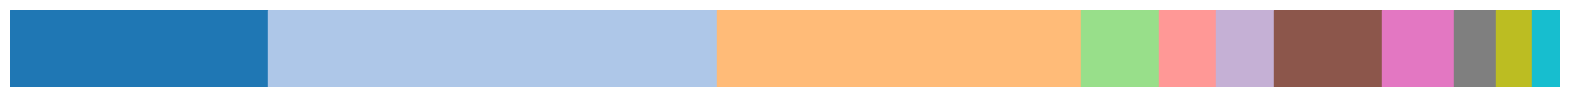

In [64]:
# 根据轨迹分隔索引画出色条
# 色条的参数
total_length = len(df_nt_mx)
height = 1 
# 创建绘图
fig, ax = plt.subplots(figsize=(20, 1))  # 设置长宽比

for i in range(len(start_index_sel) - 1):
    start = start_index_sel[i]
    end = start_index_sel[i + 1]
    color = colors_list[i % len(colors_list)]  # 循环分配颜色
    
    # 绘制矩形
    ax.add_patch(plt.Rectangle((start, 0), end - start, height, color=color))

# 设置坐标轴和图形属性
ax.set_xlim(0, total_length)
ax.set_ylim(0, height)
ax.axis('off')  # 隐藏坐标轴

plt.show()

C:\Users\Windows11\AppData\Local\Temp\ipykernel_22712\59215339.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = (20,5))


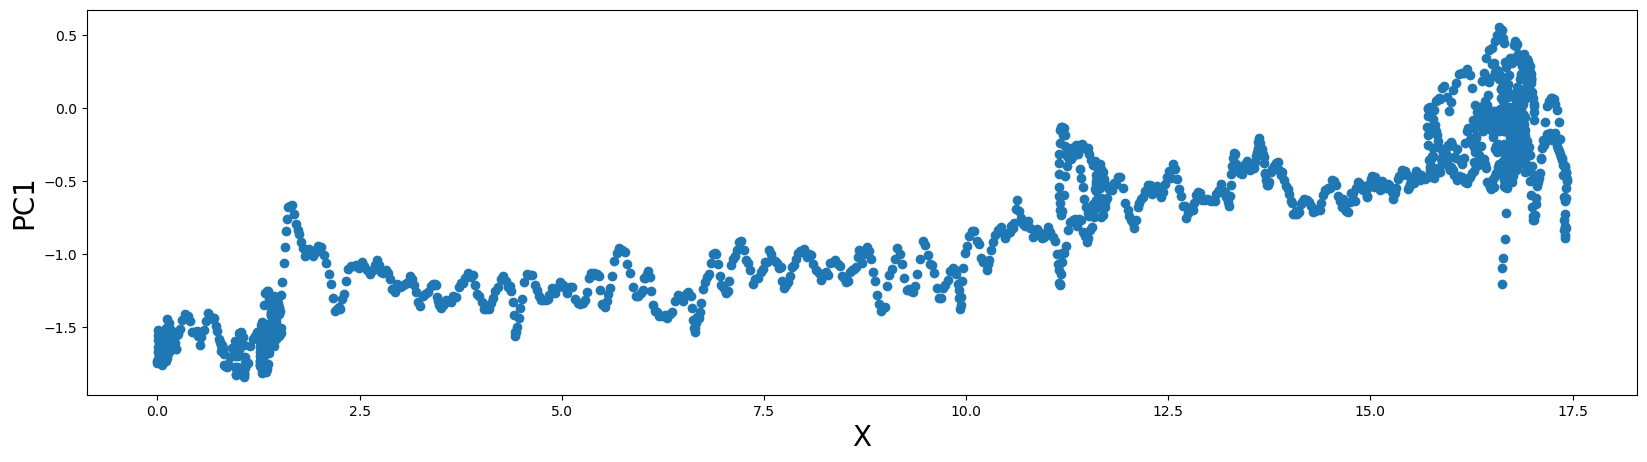

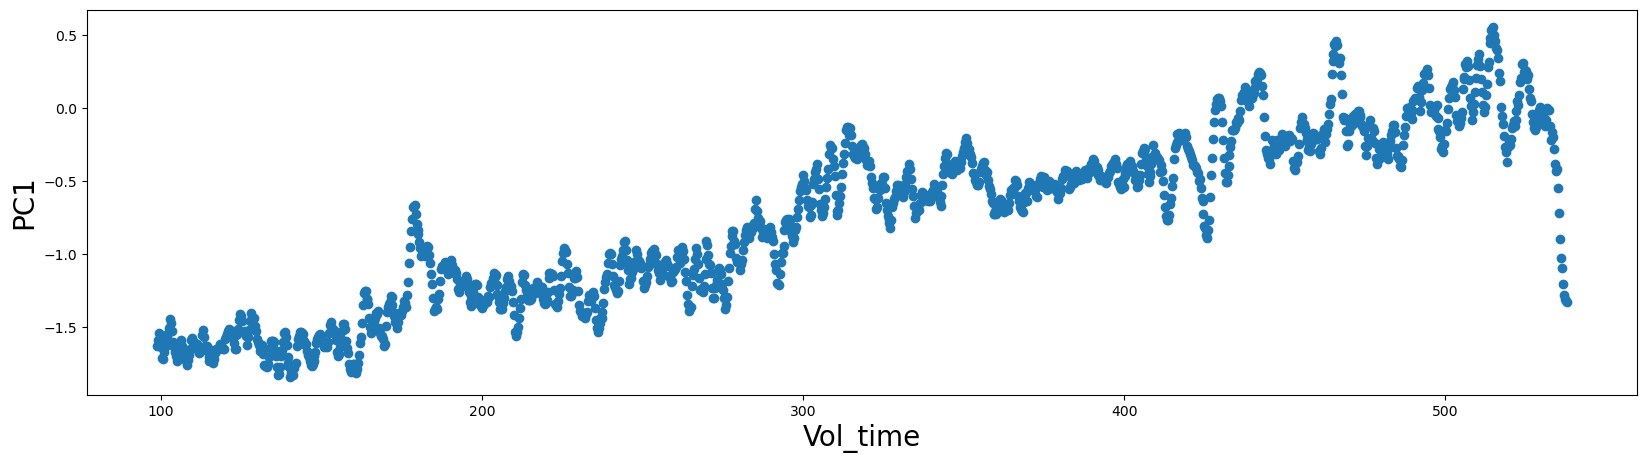

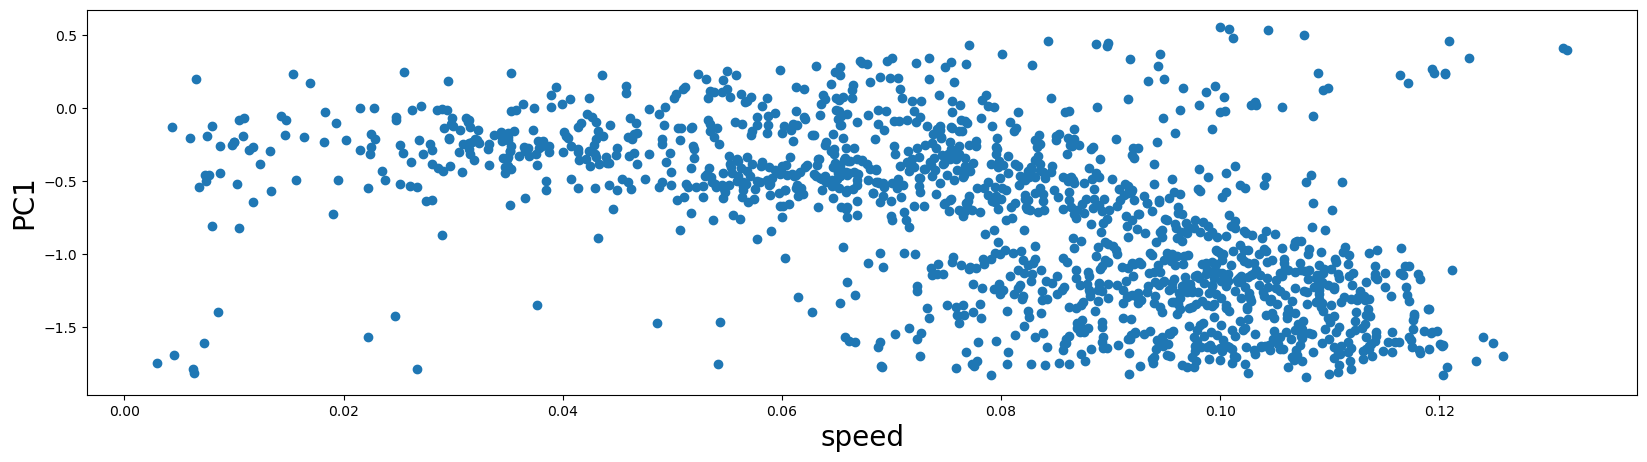

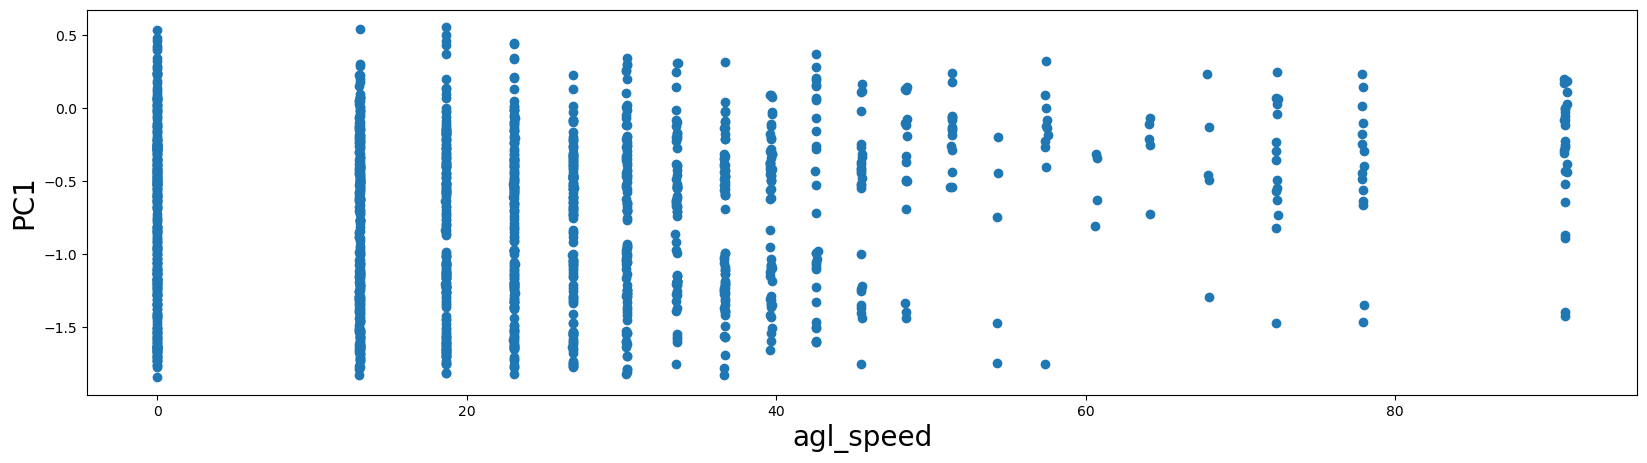

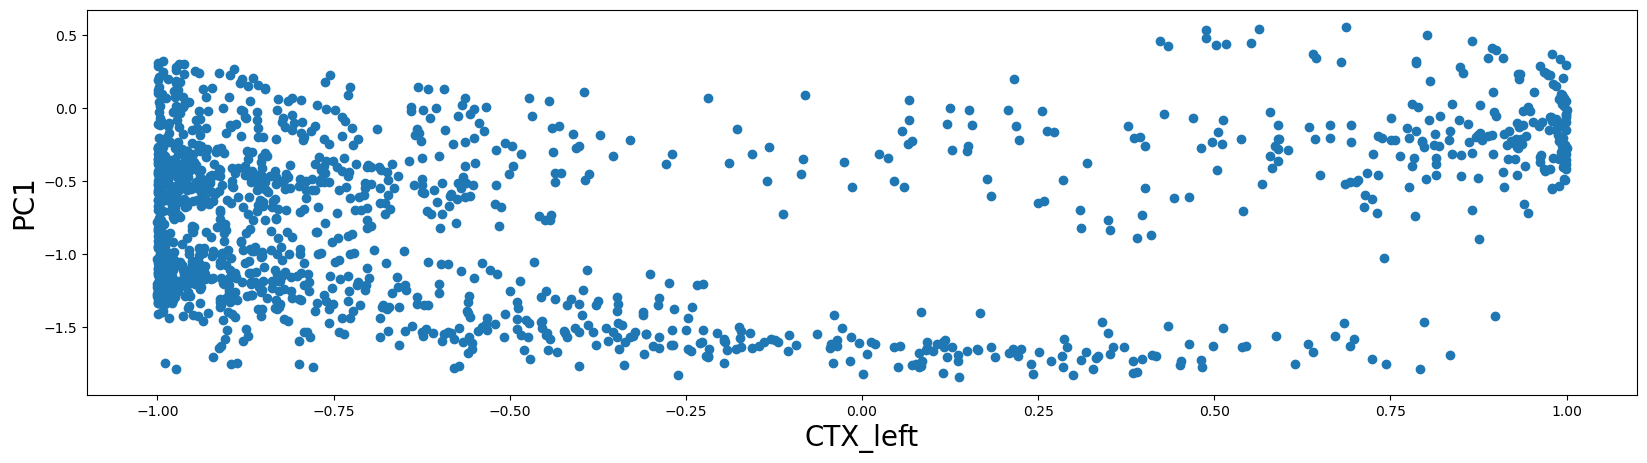

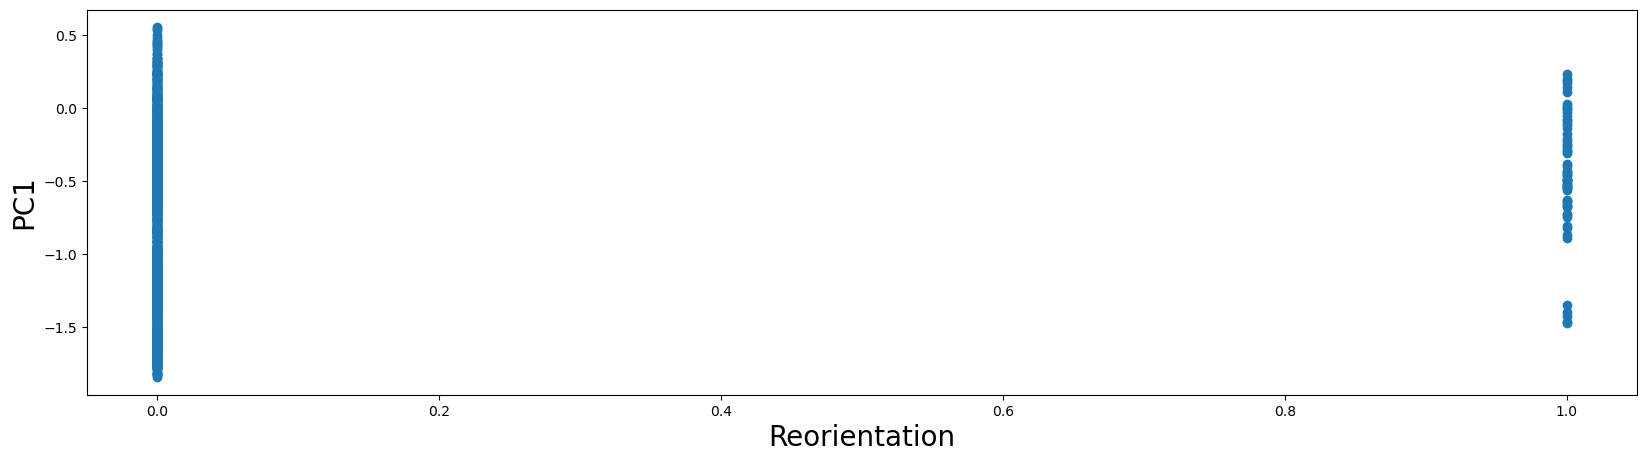

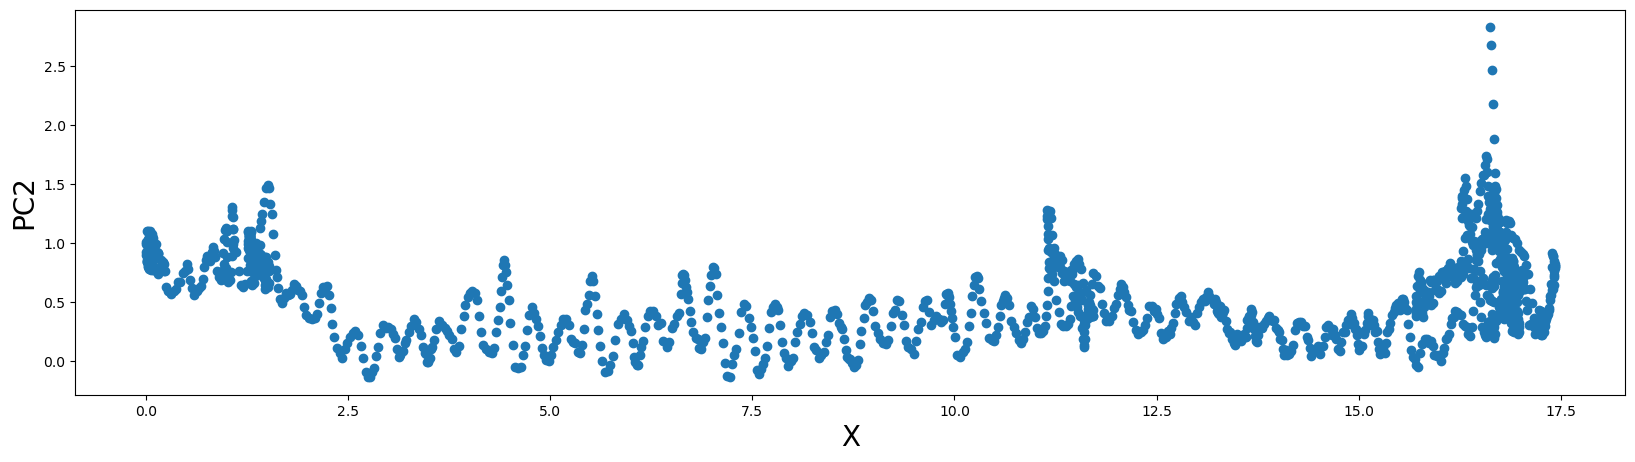

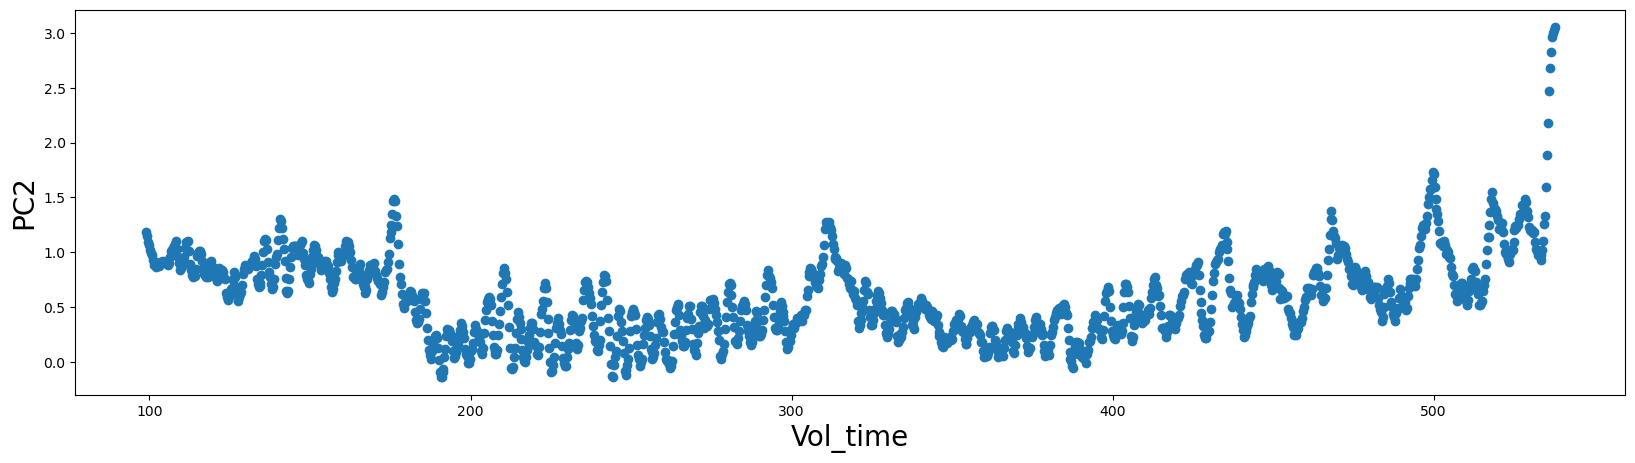

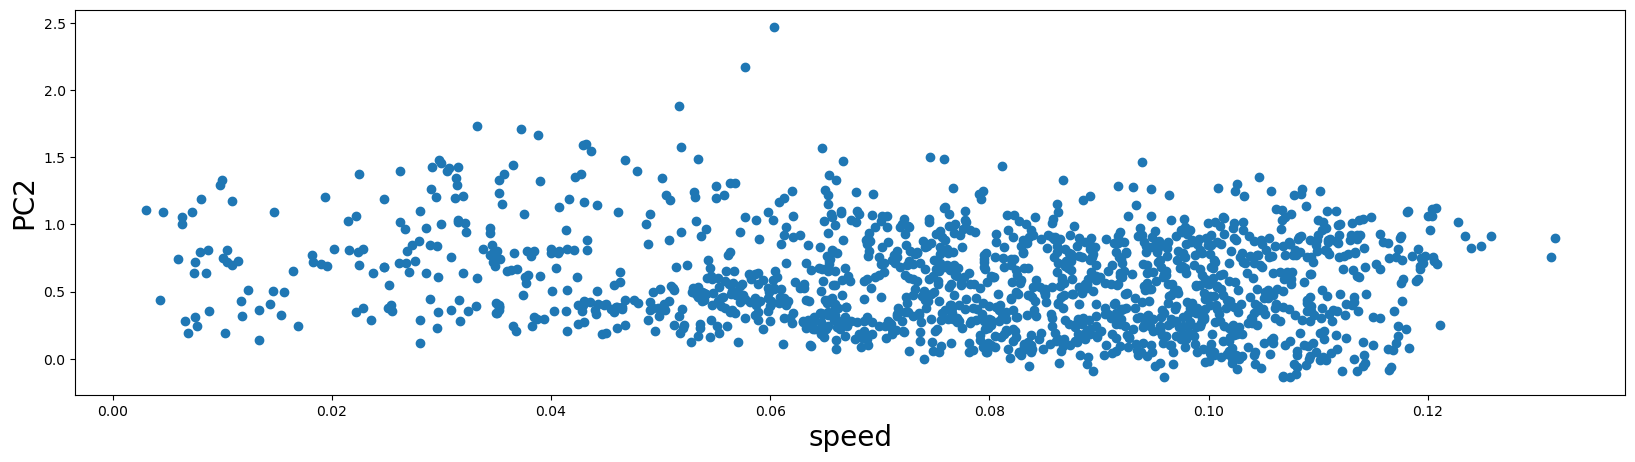

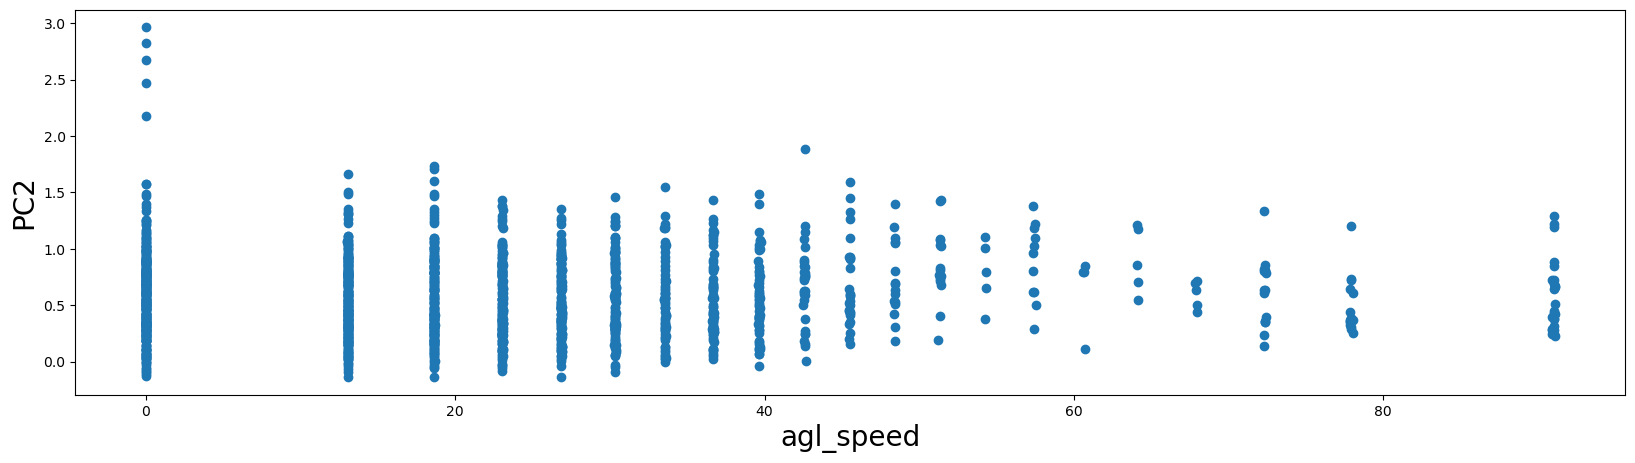

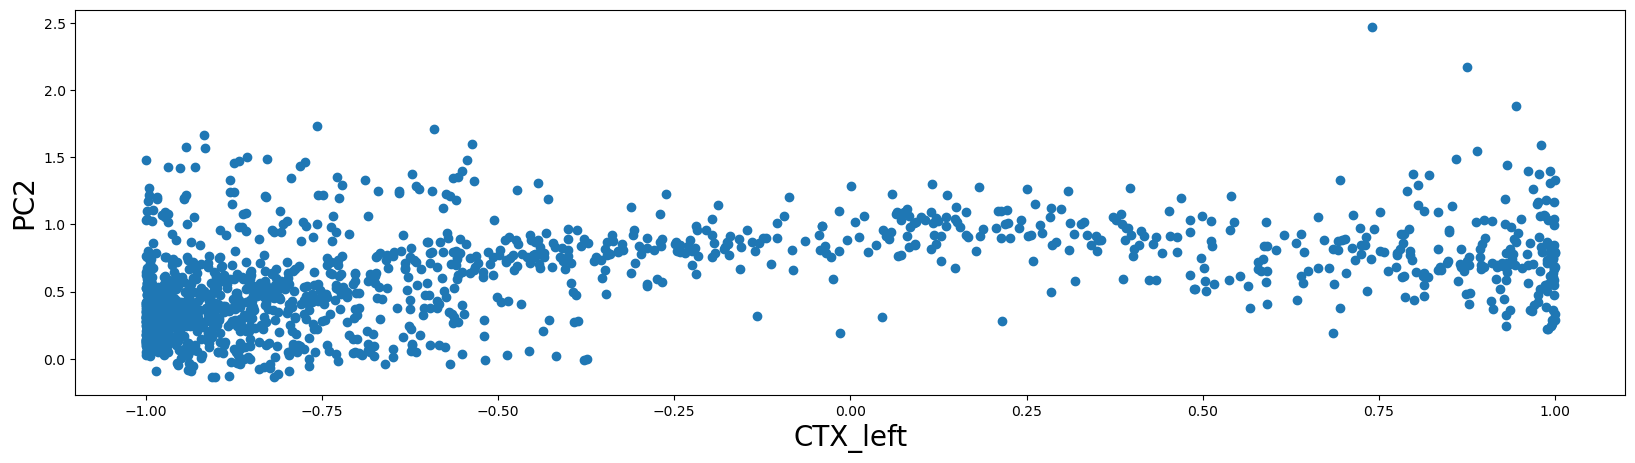

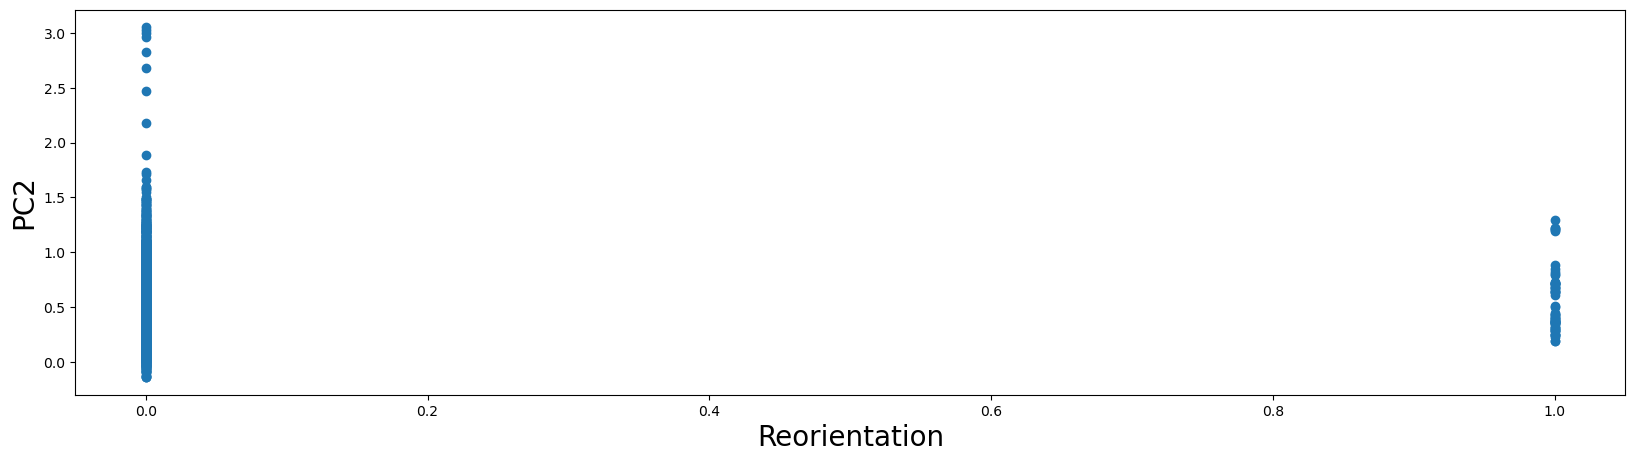

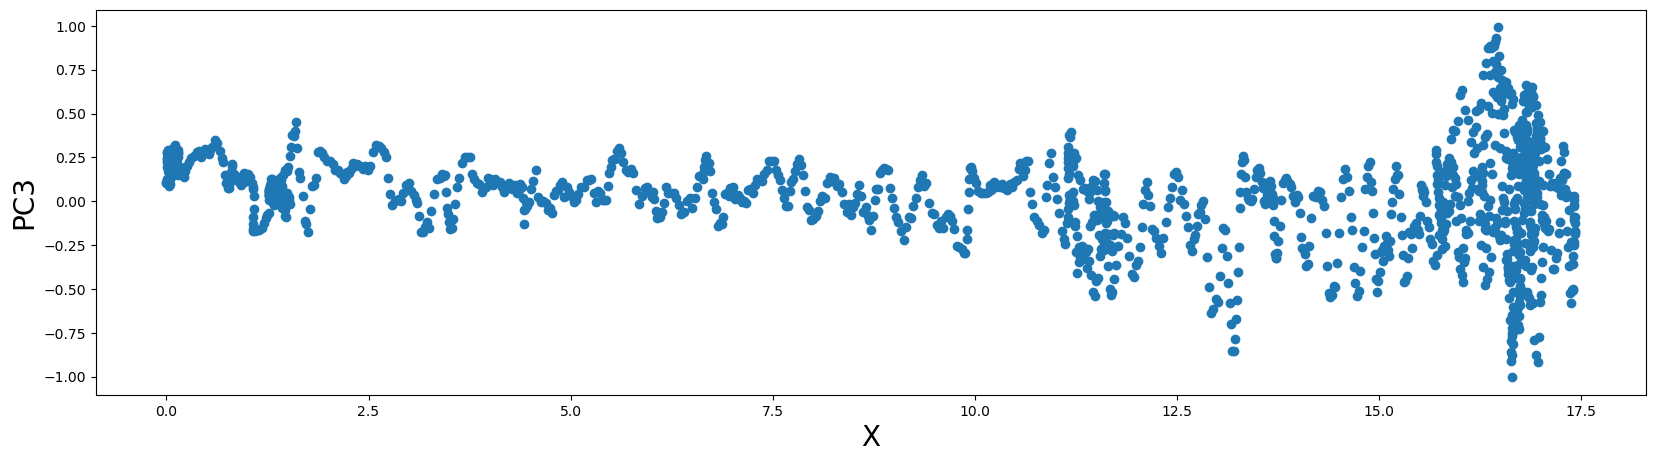

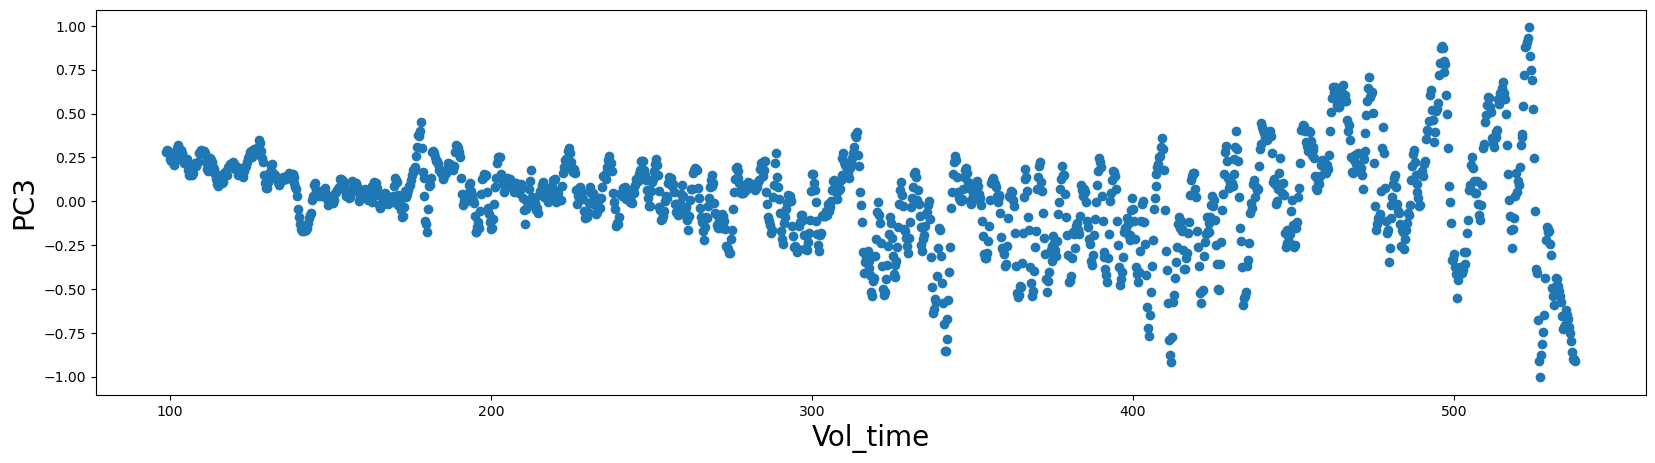

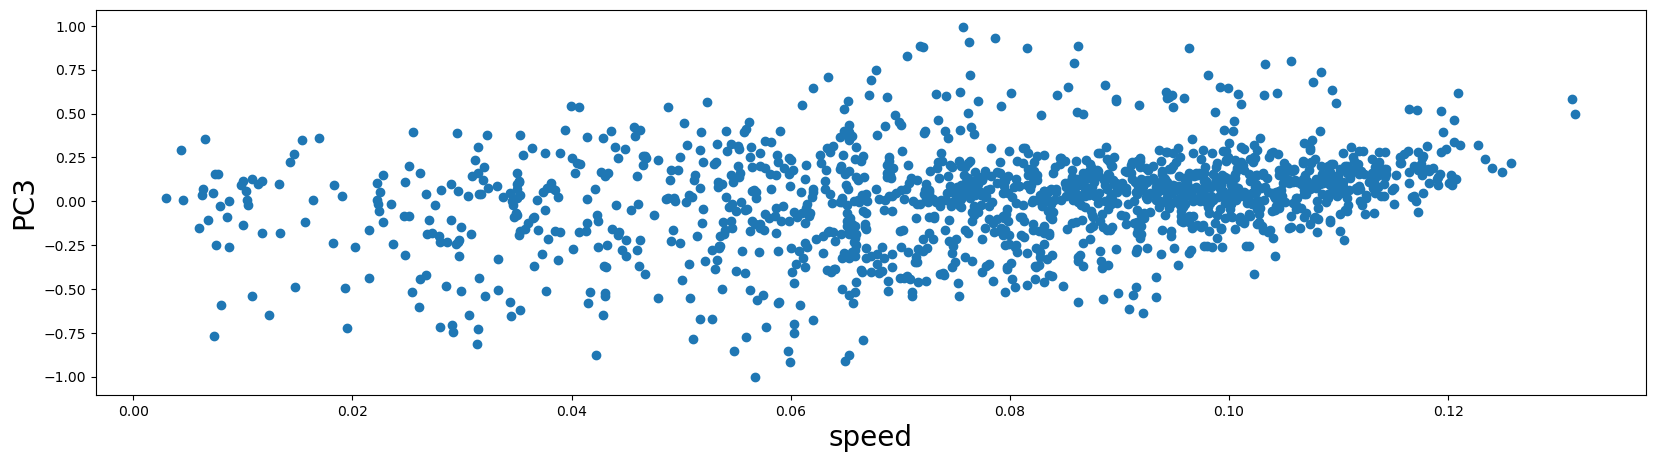

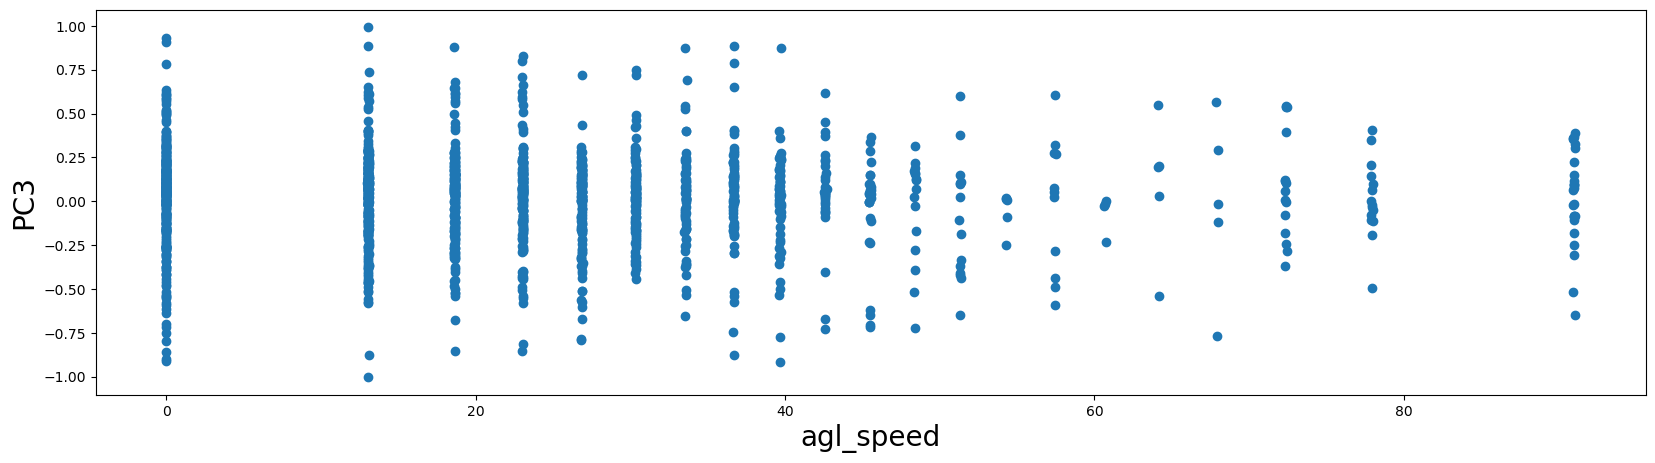

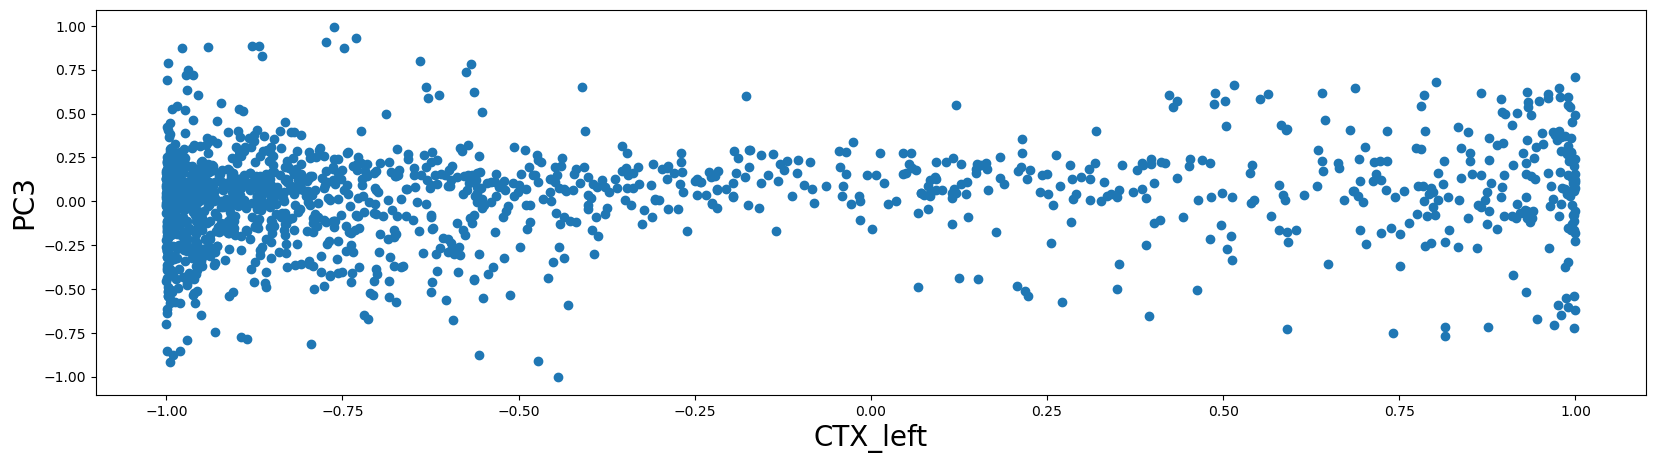

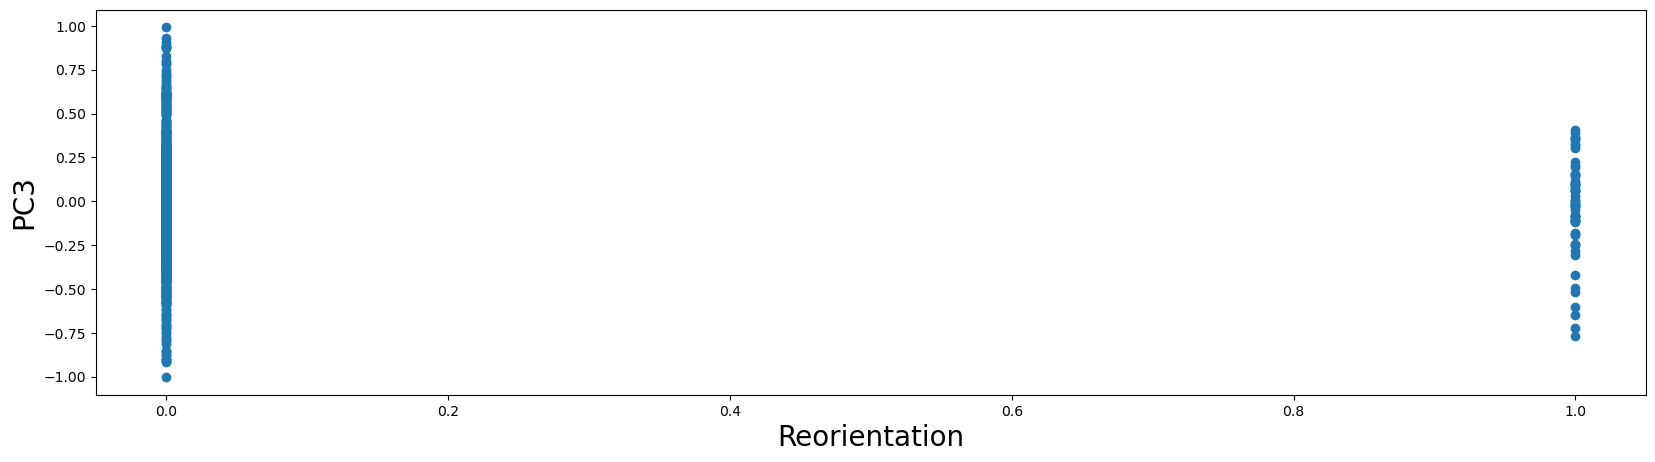

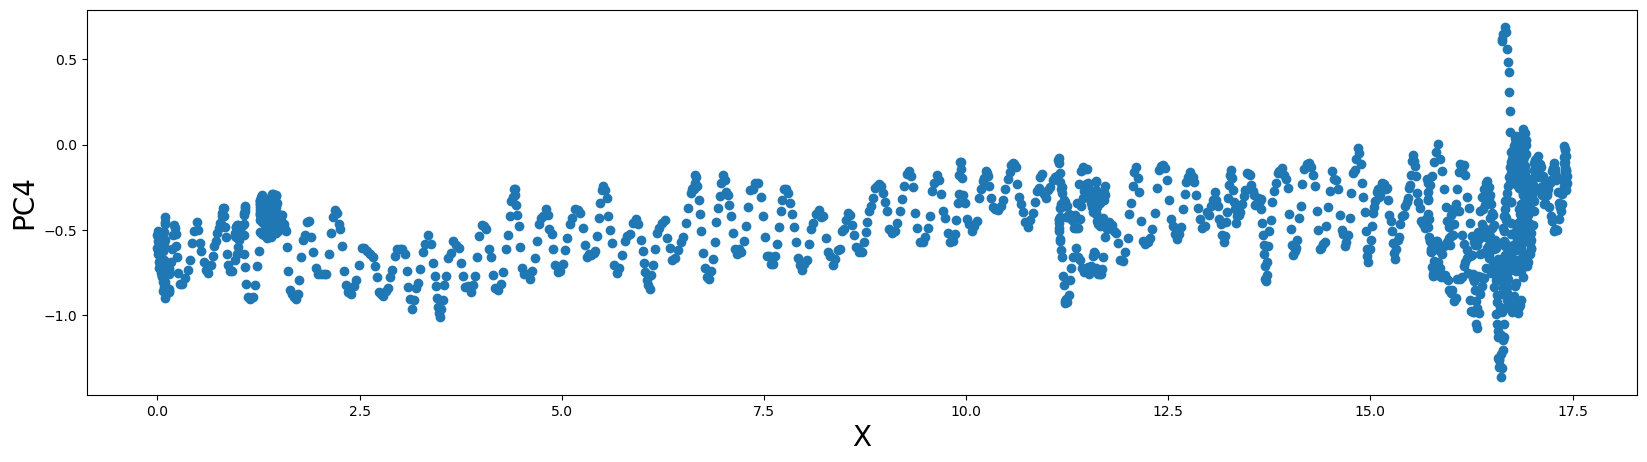

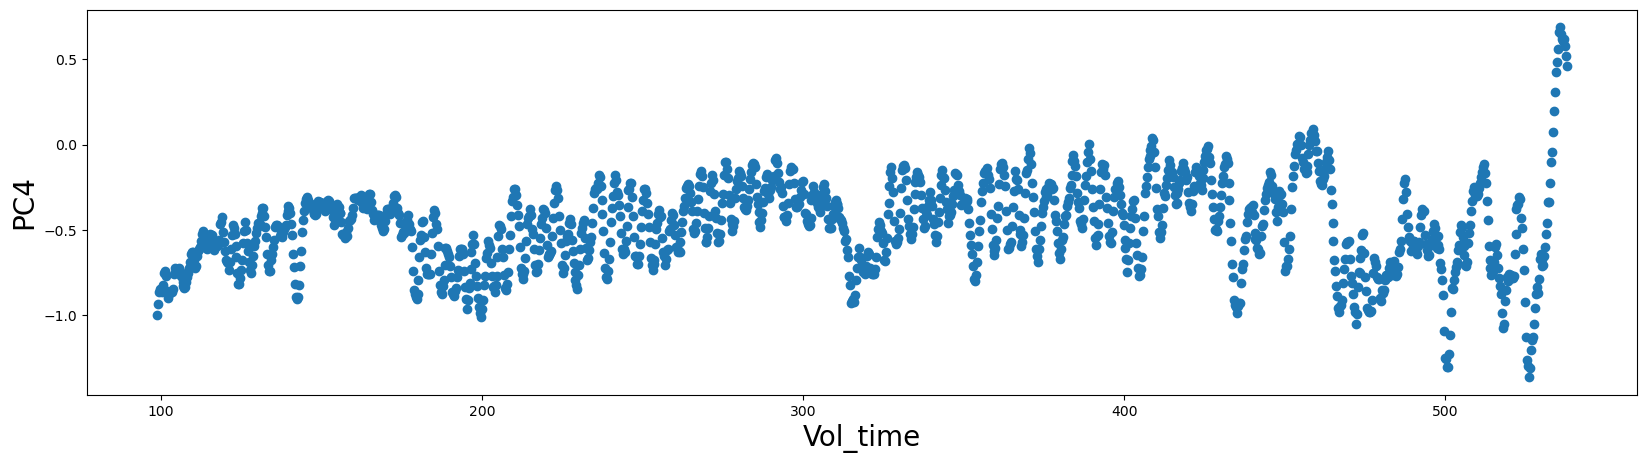

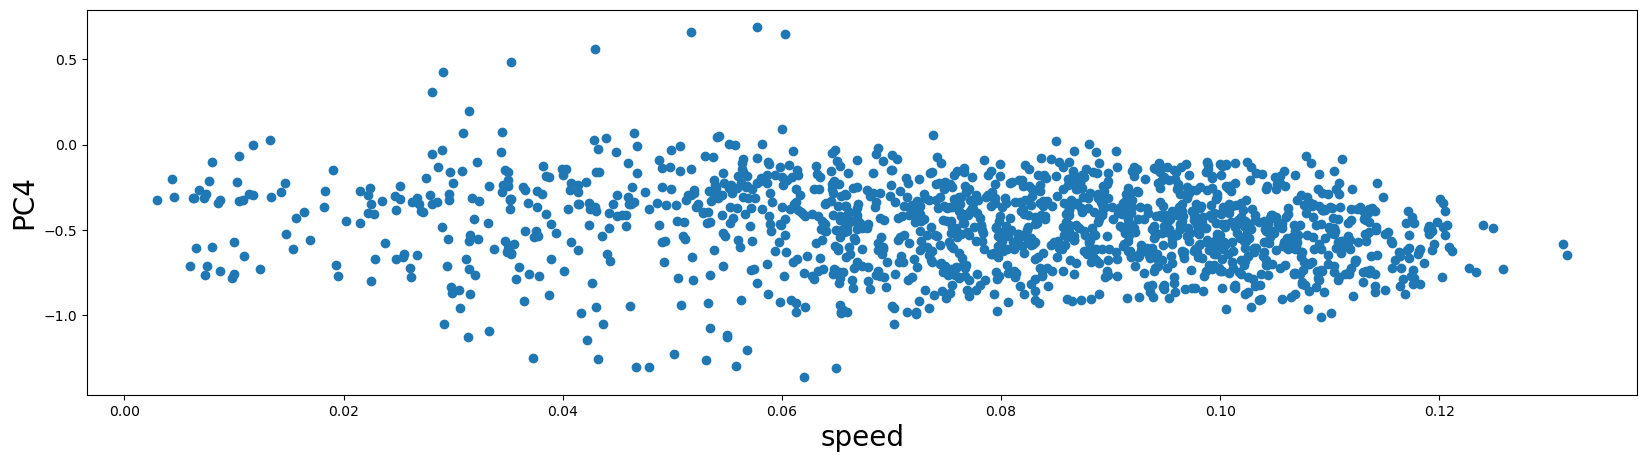

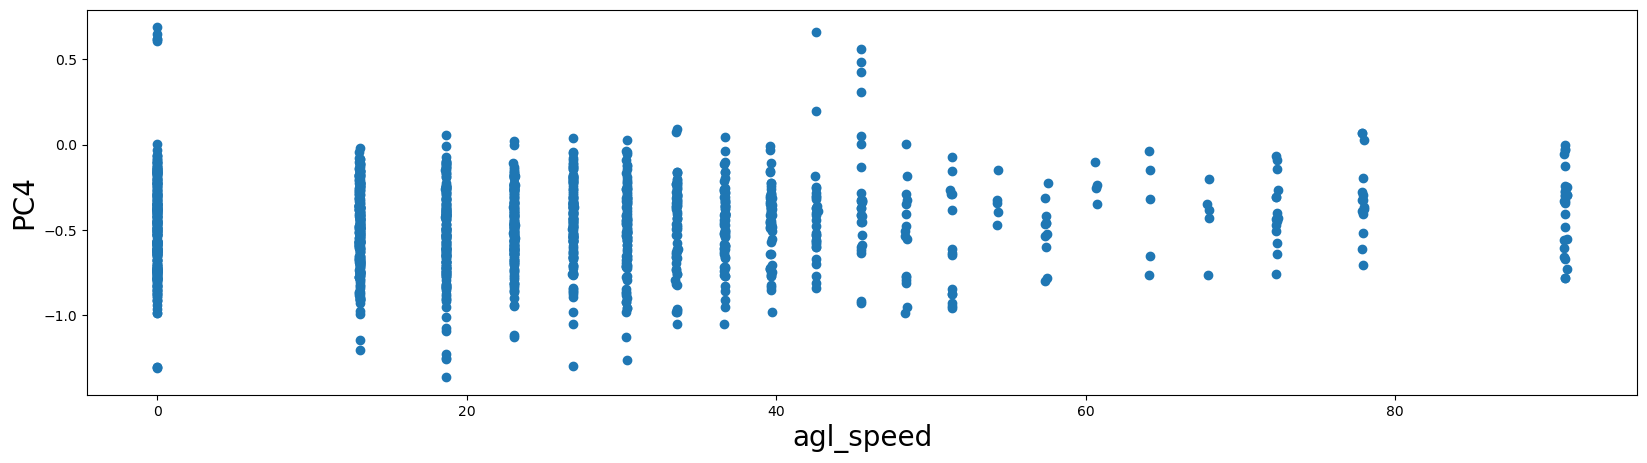

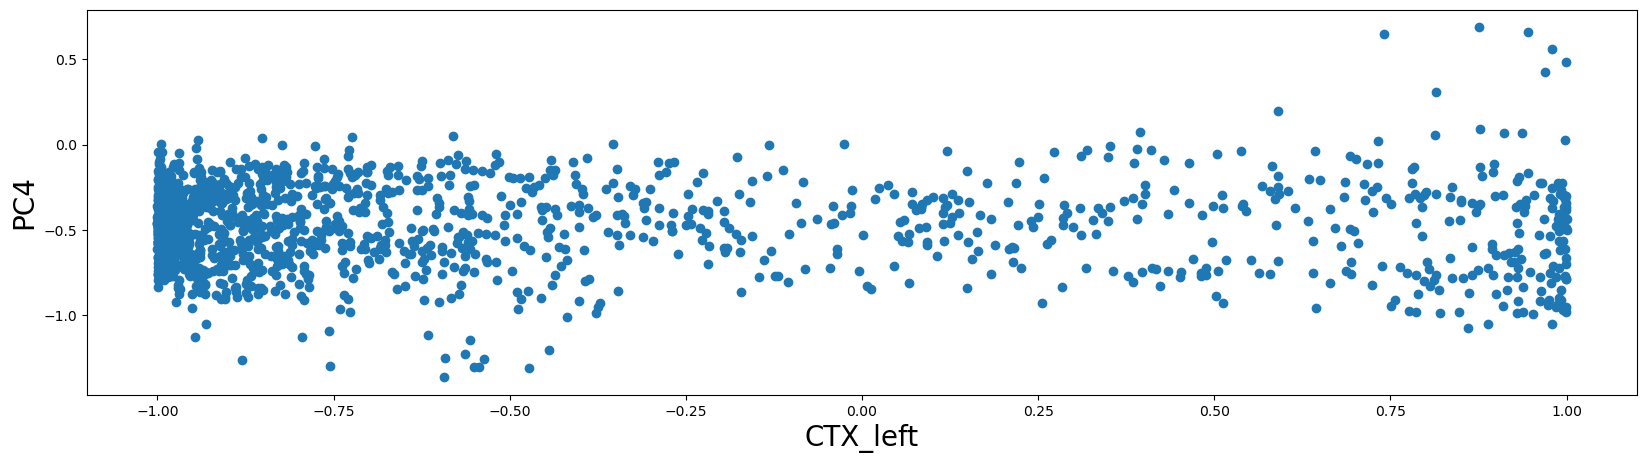

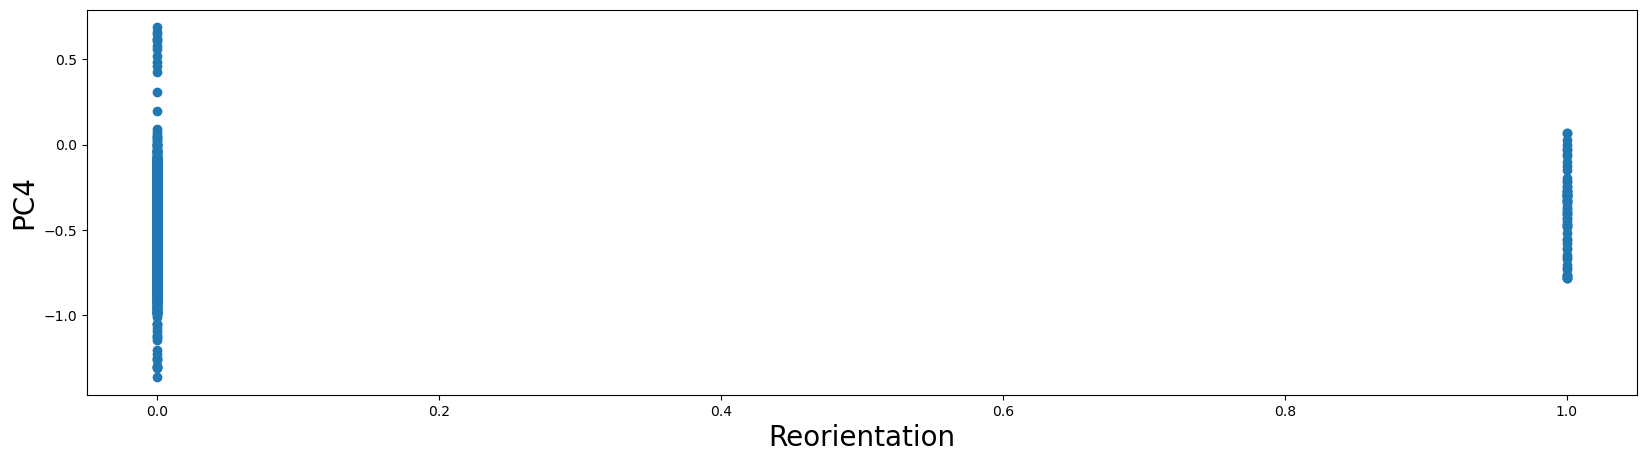

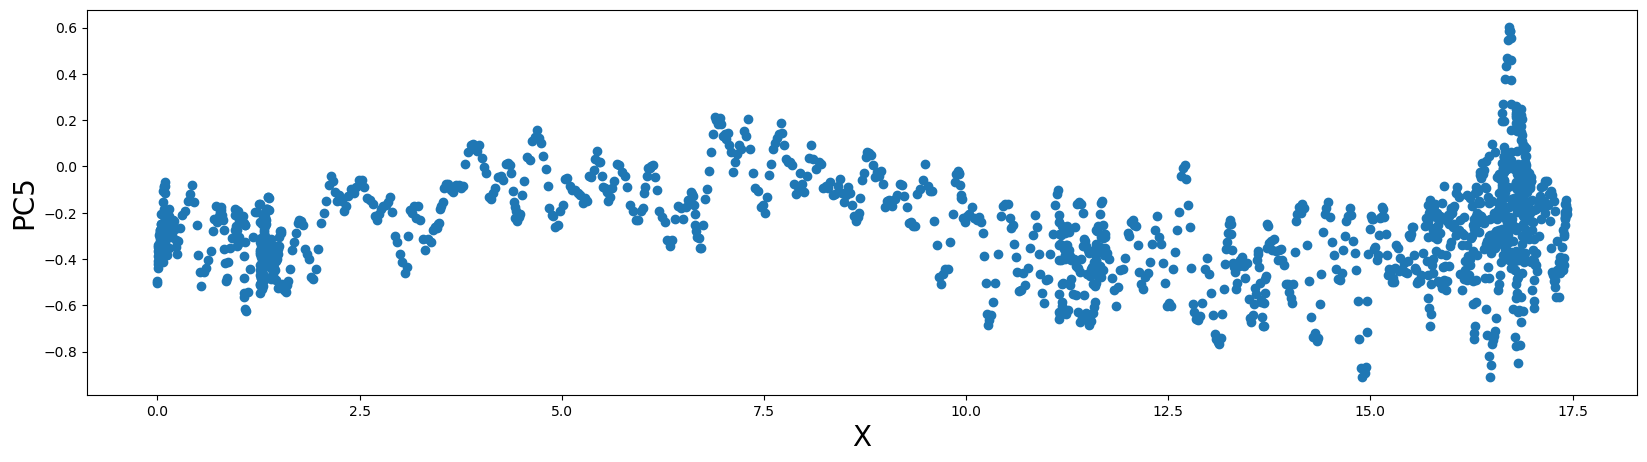

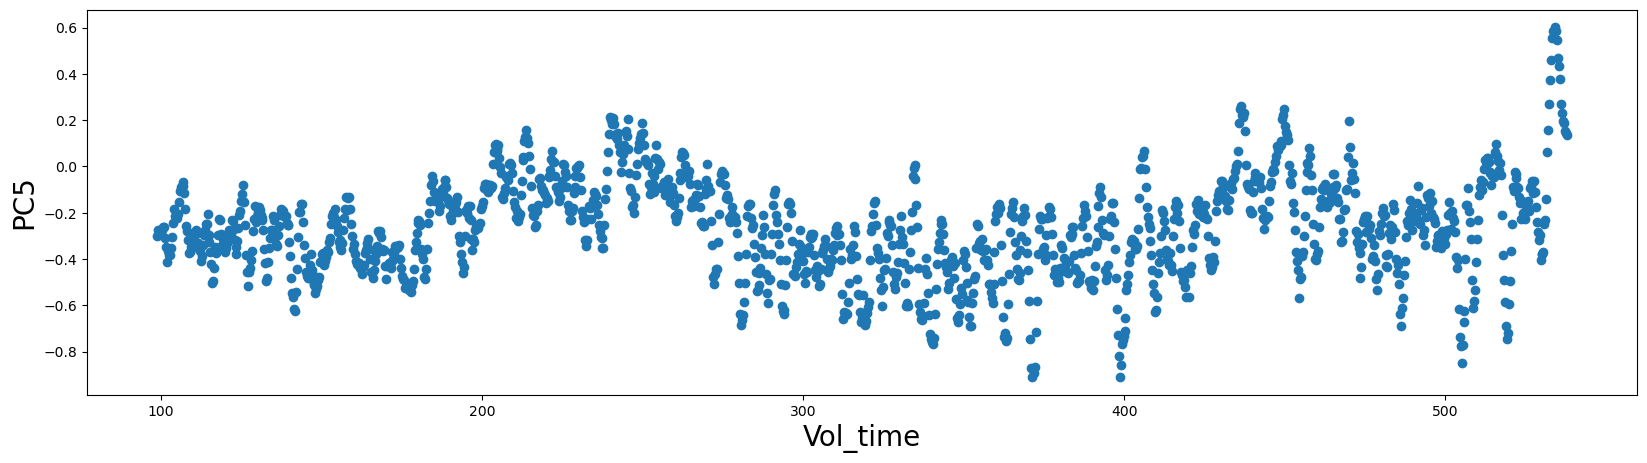

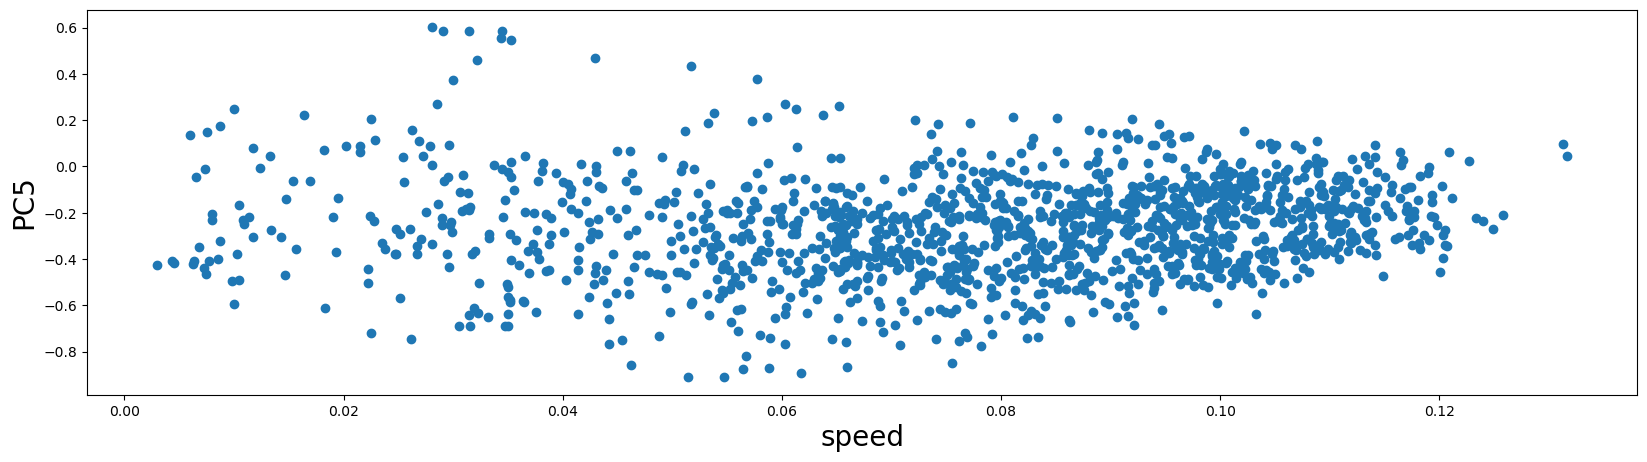

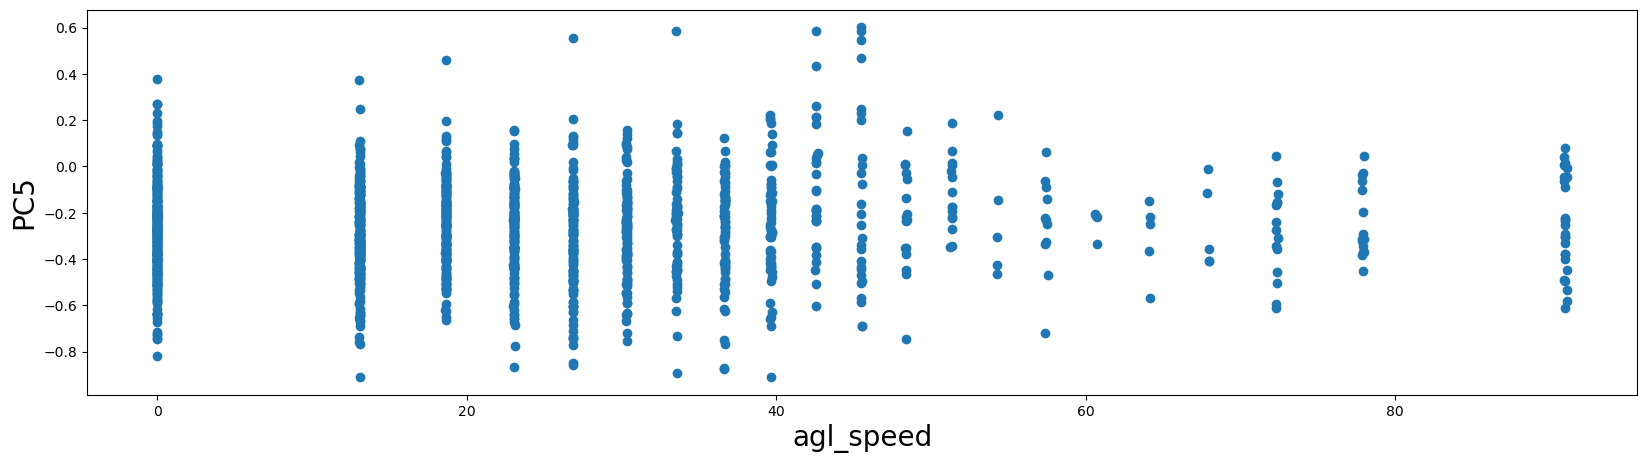

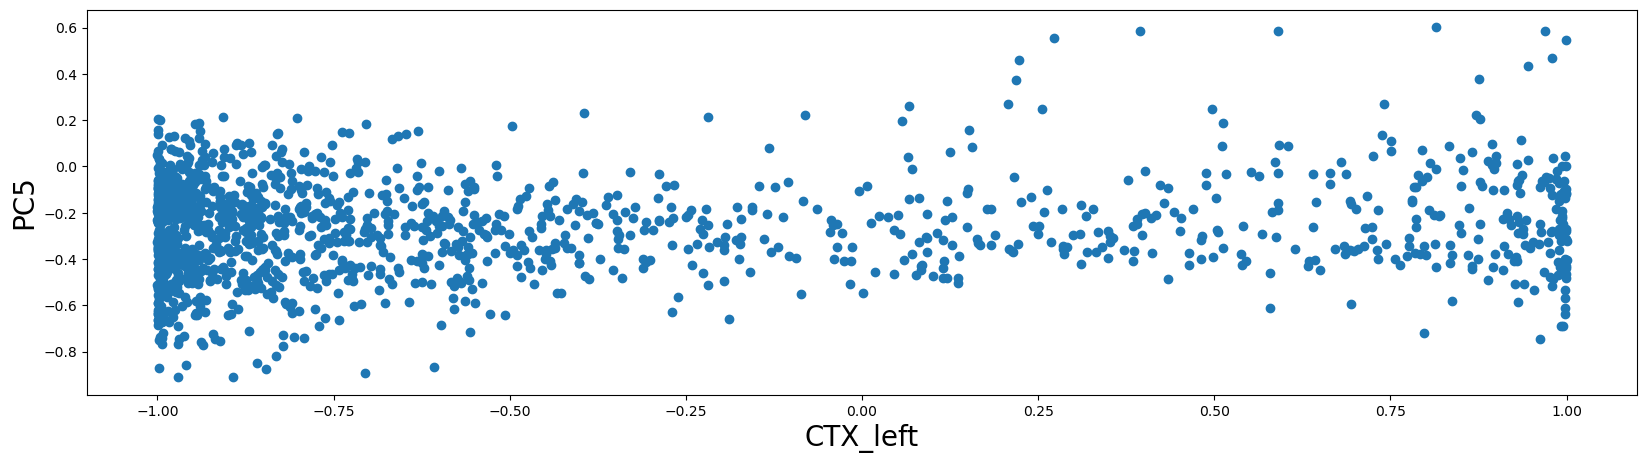

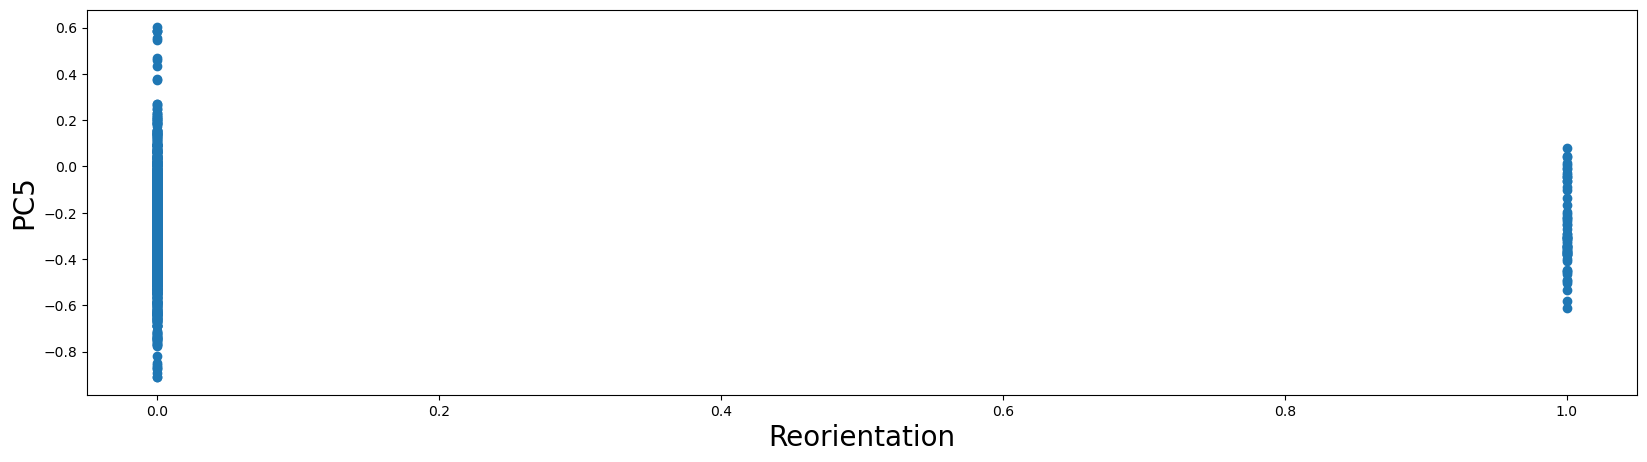

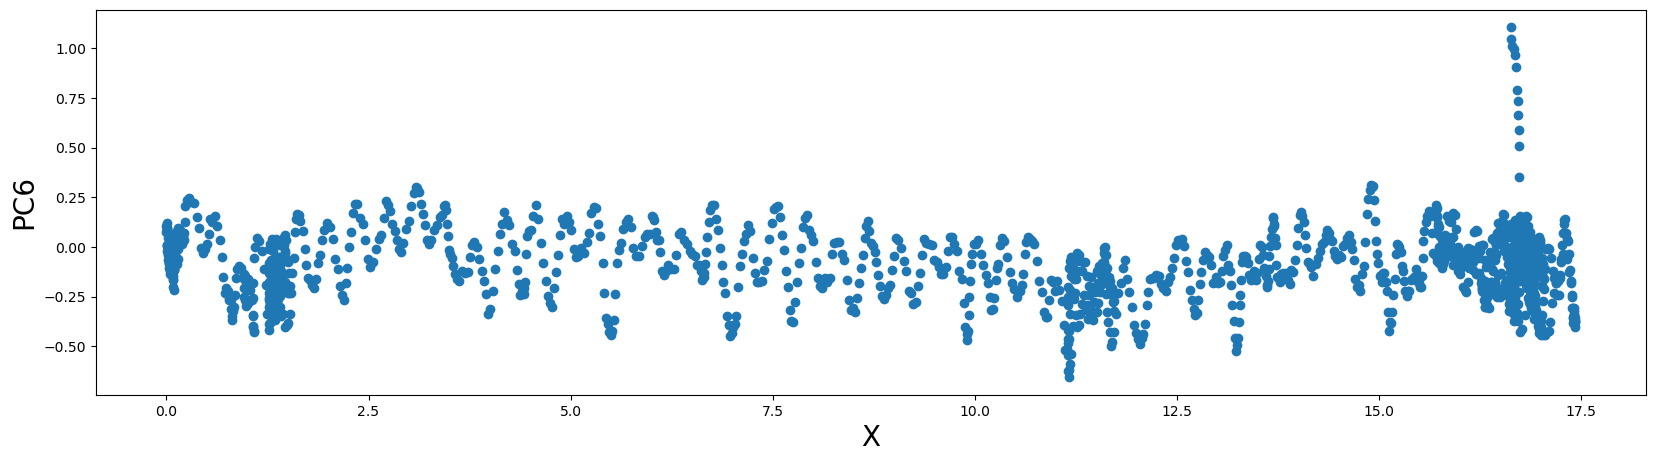

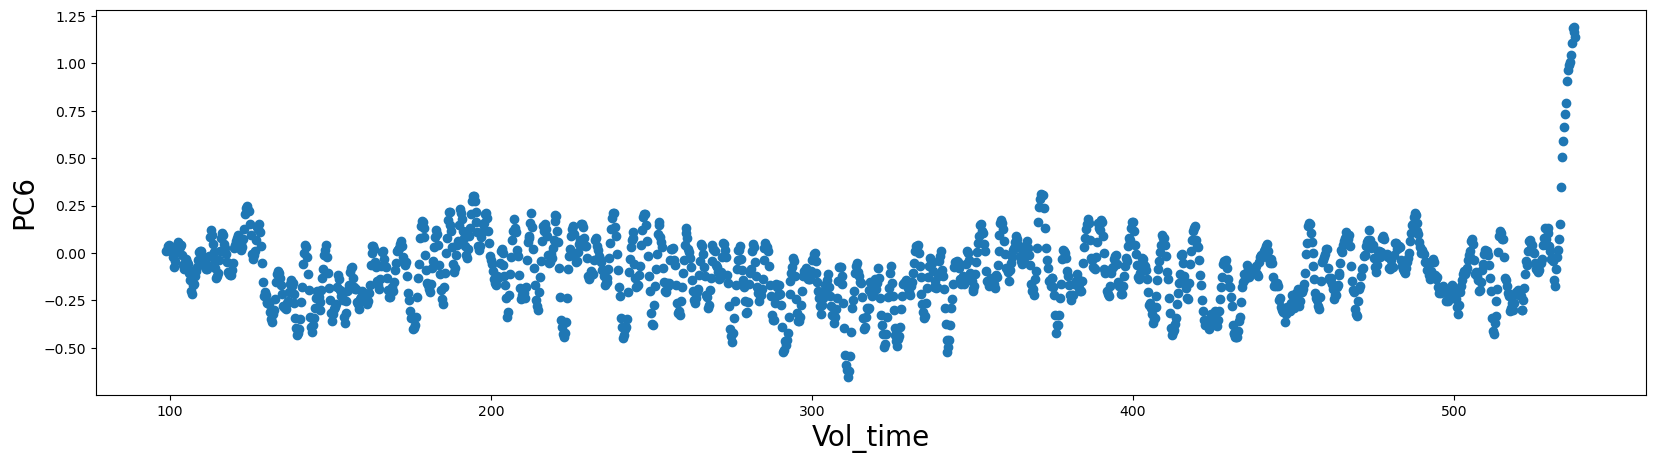

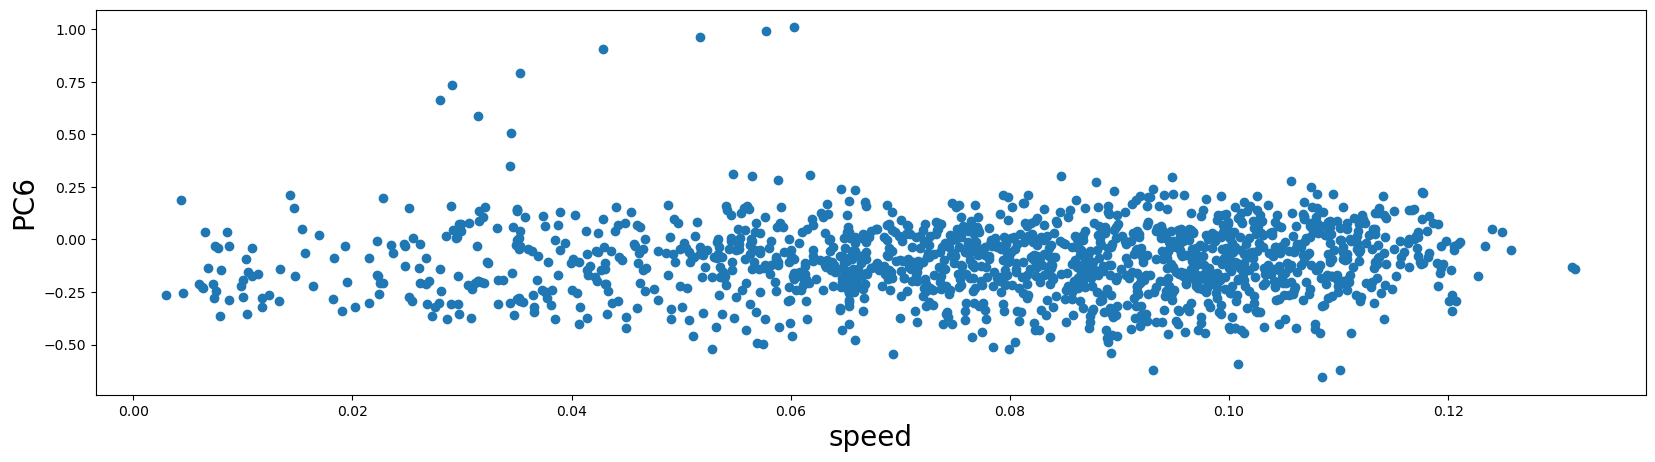

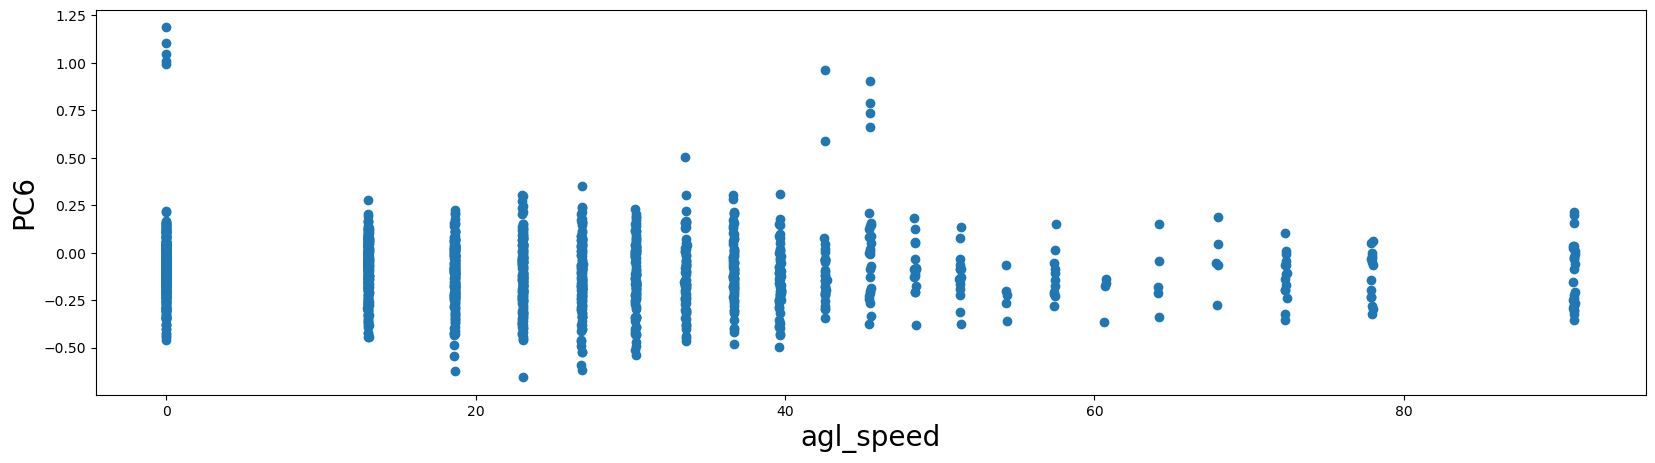

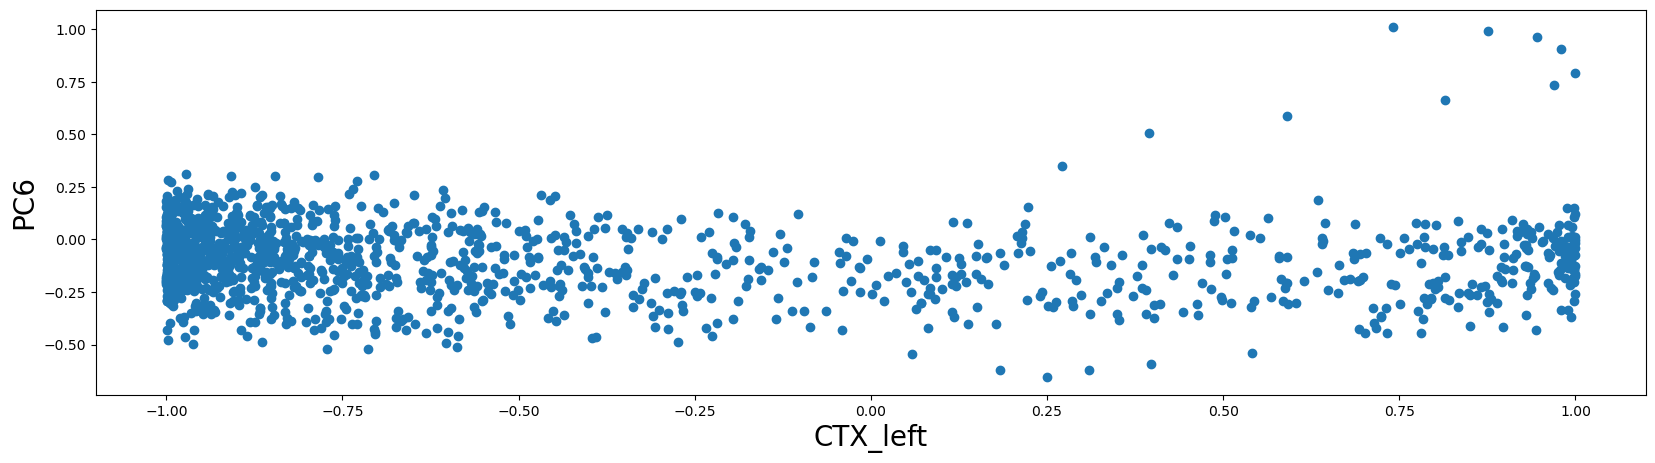

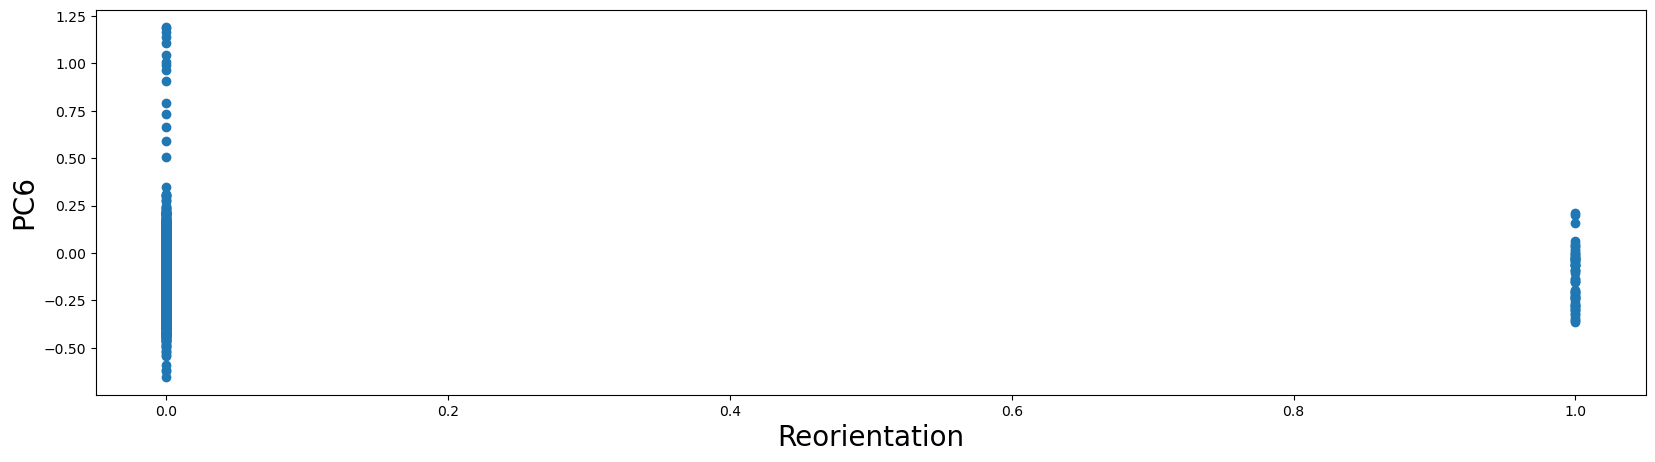

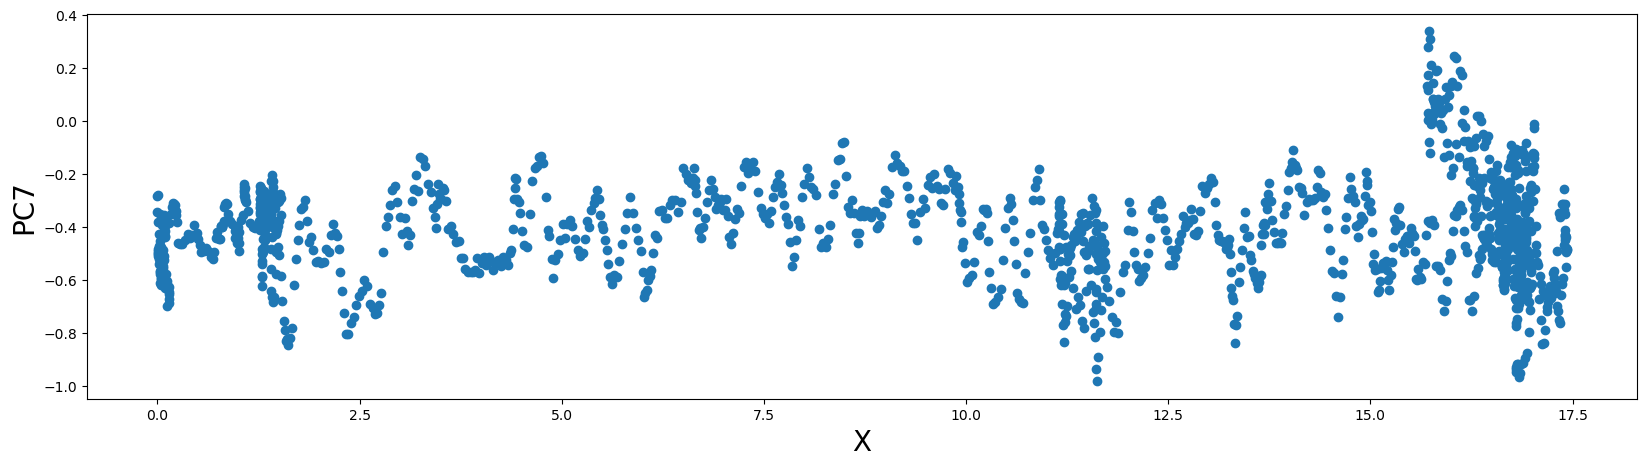

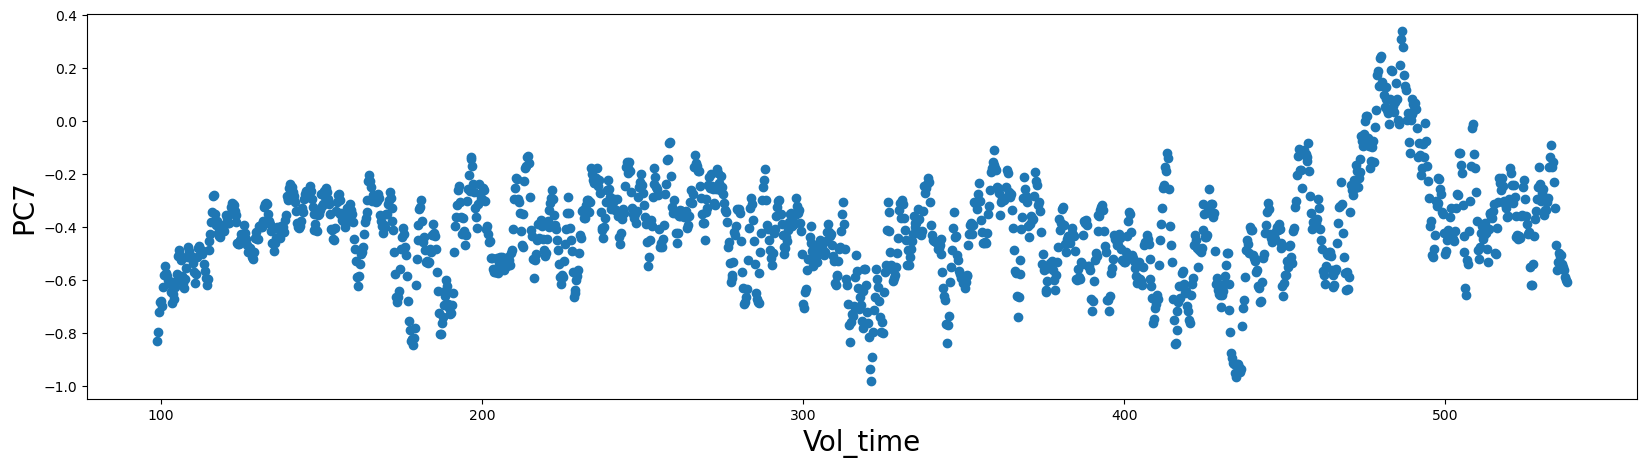

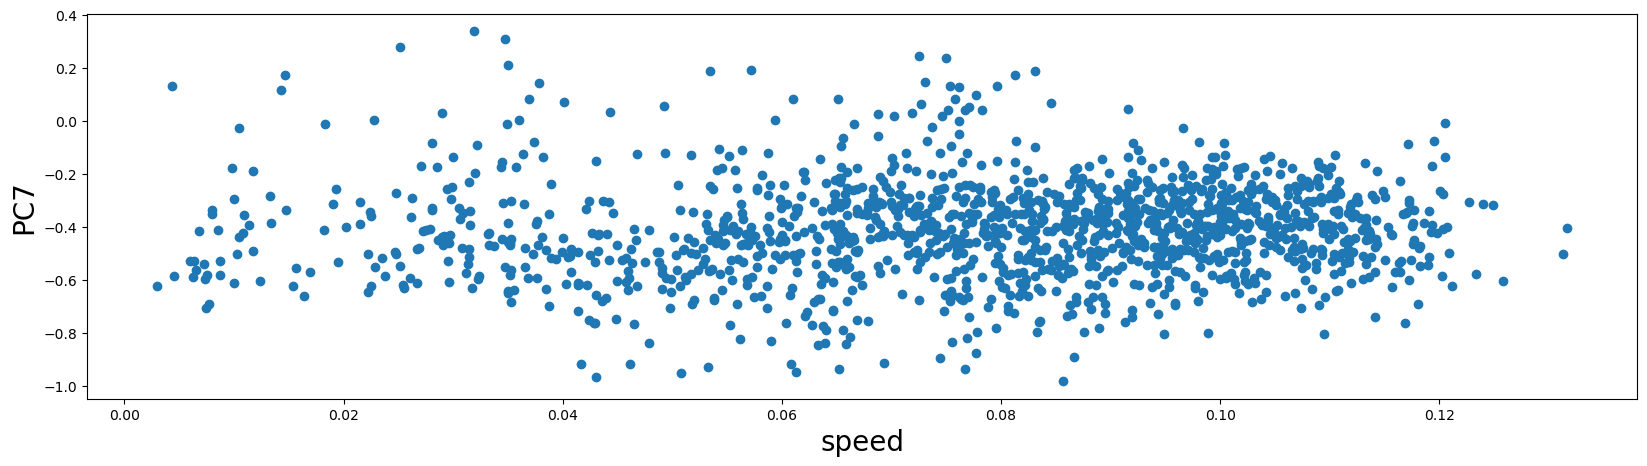

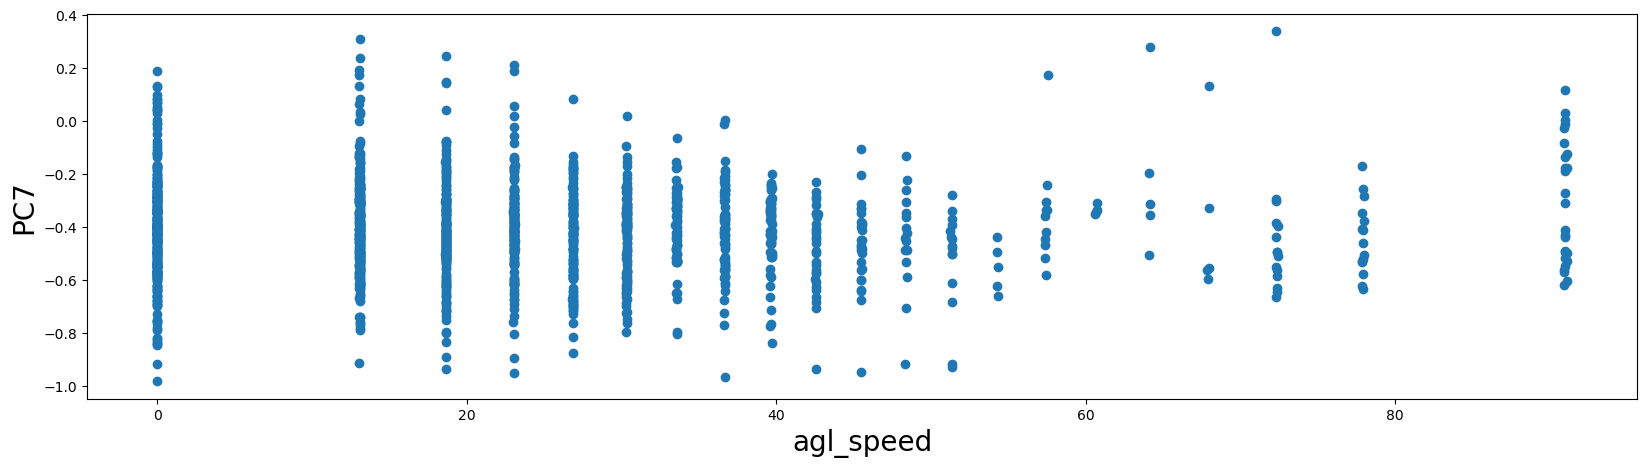

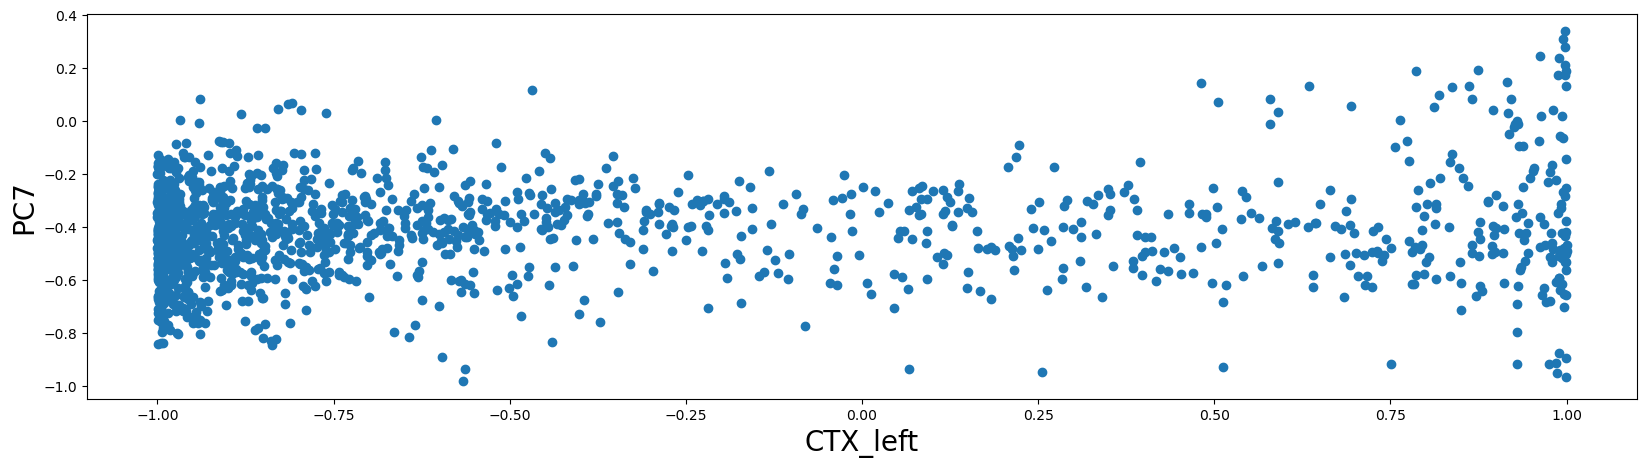

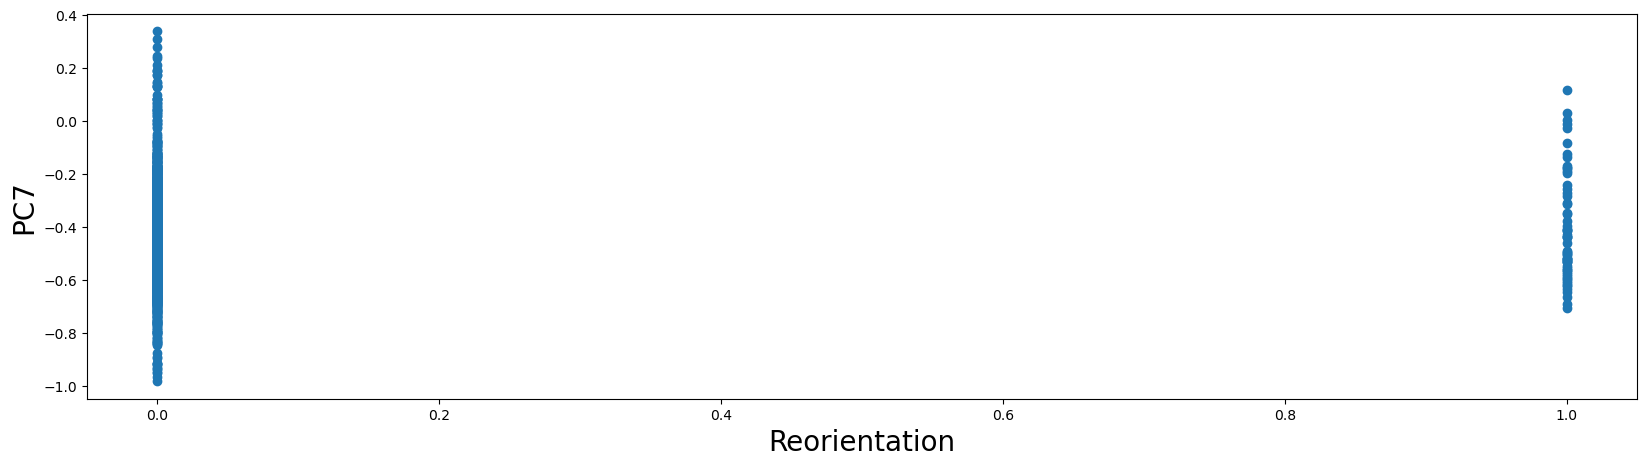

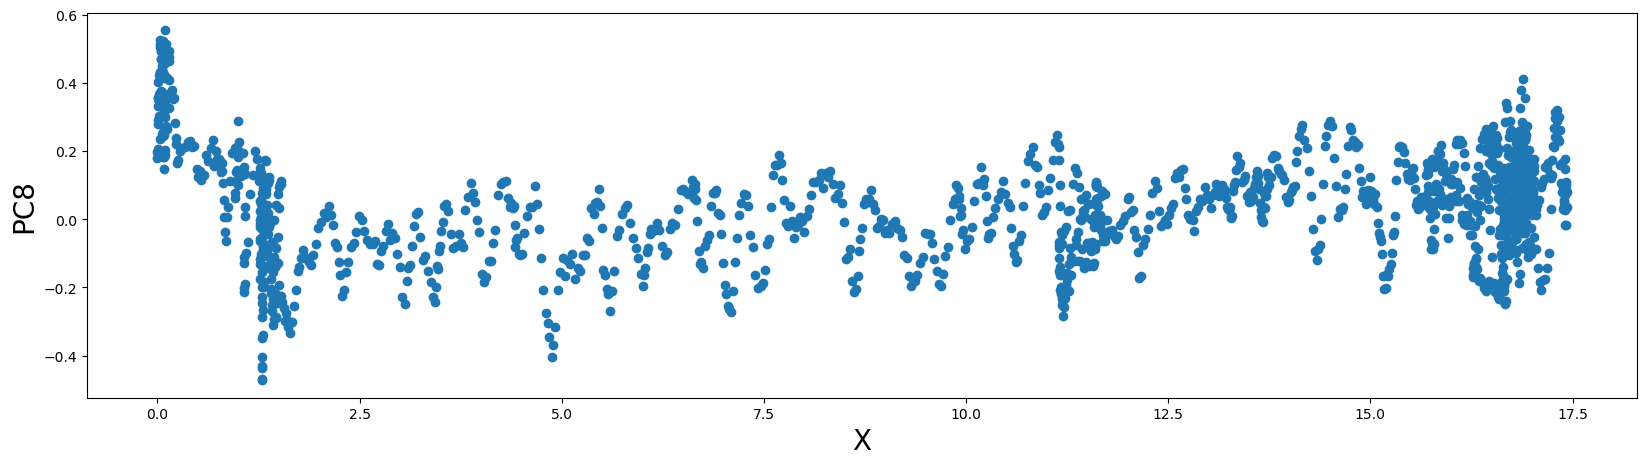

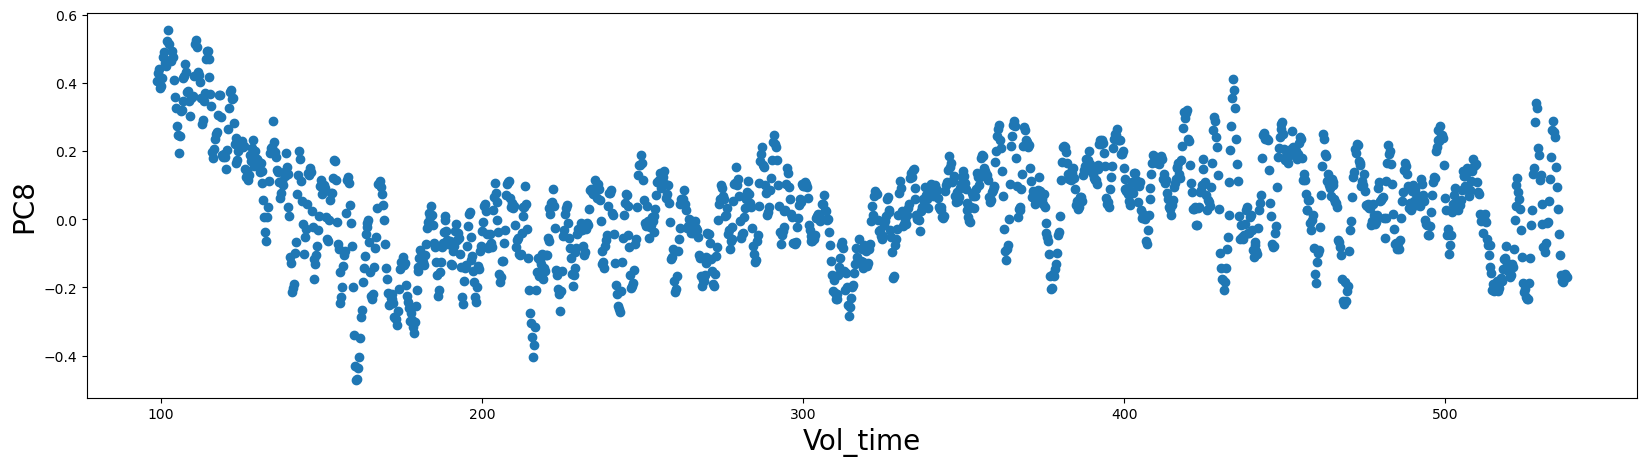

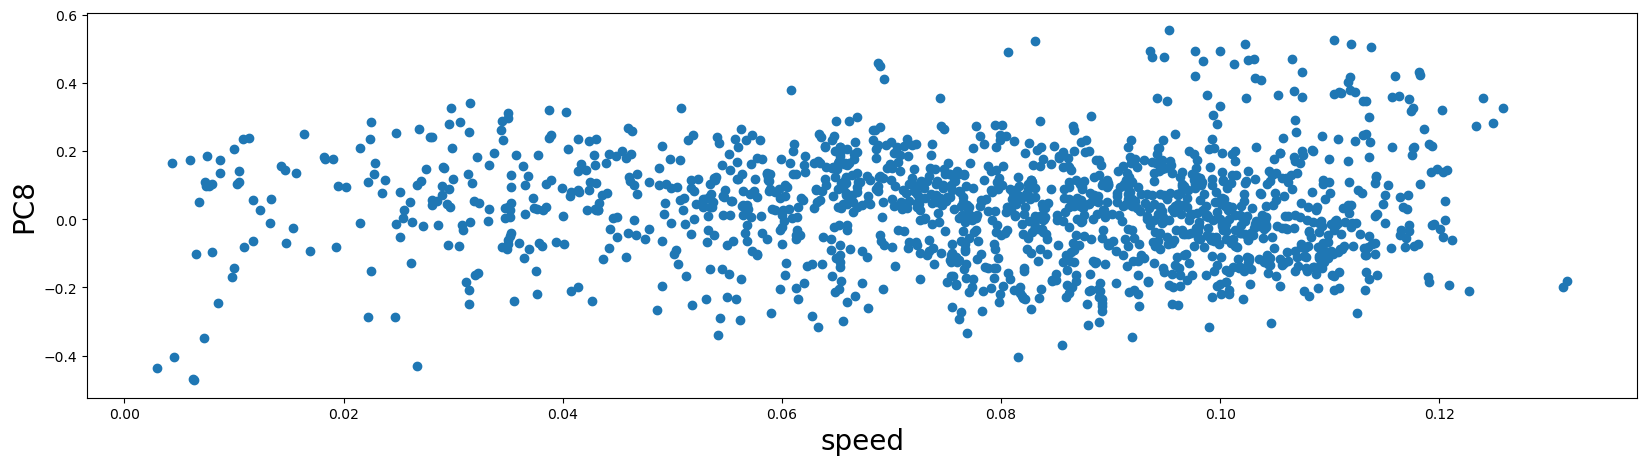

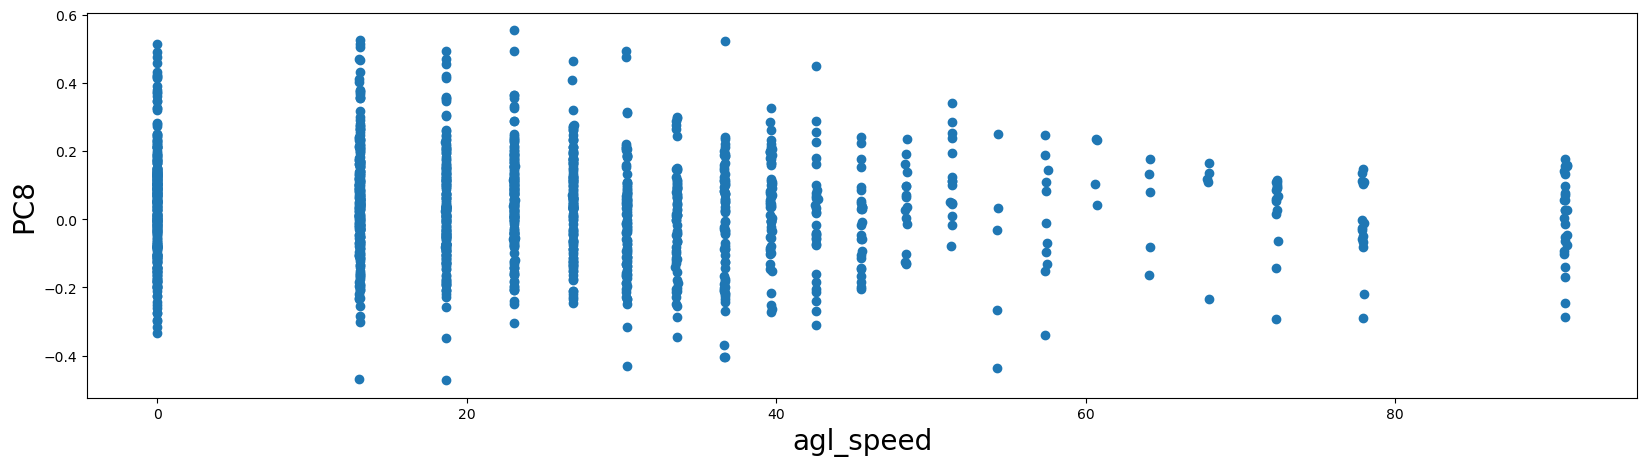

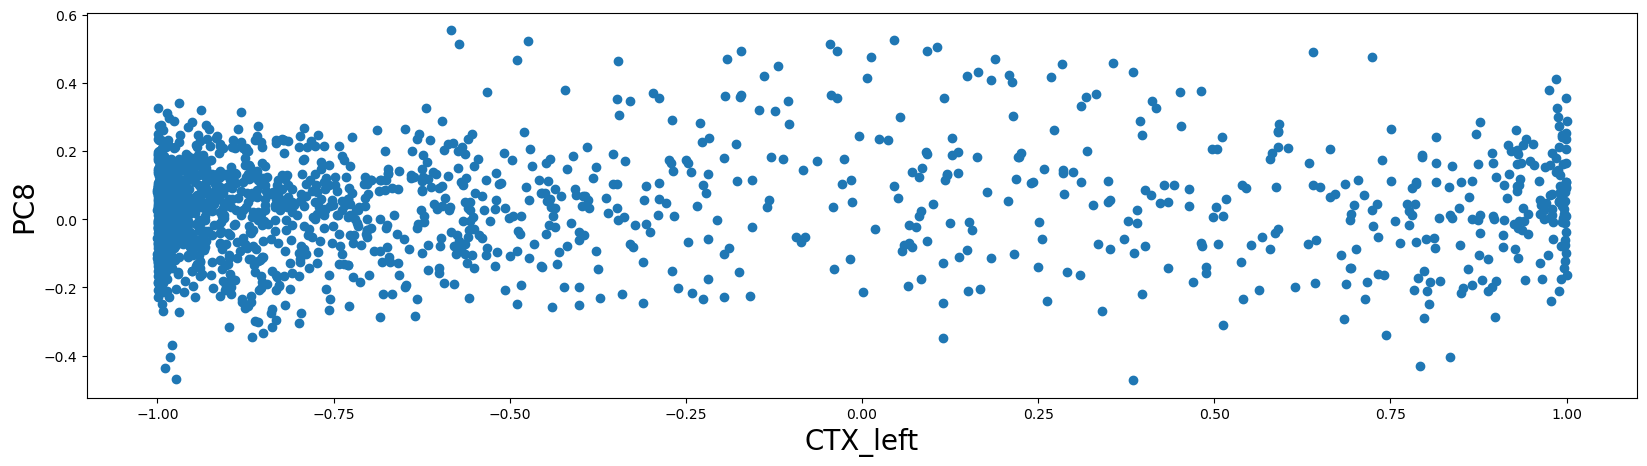

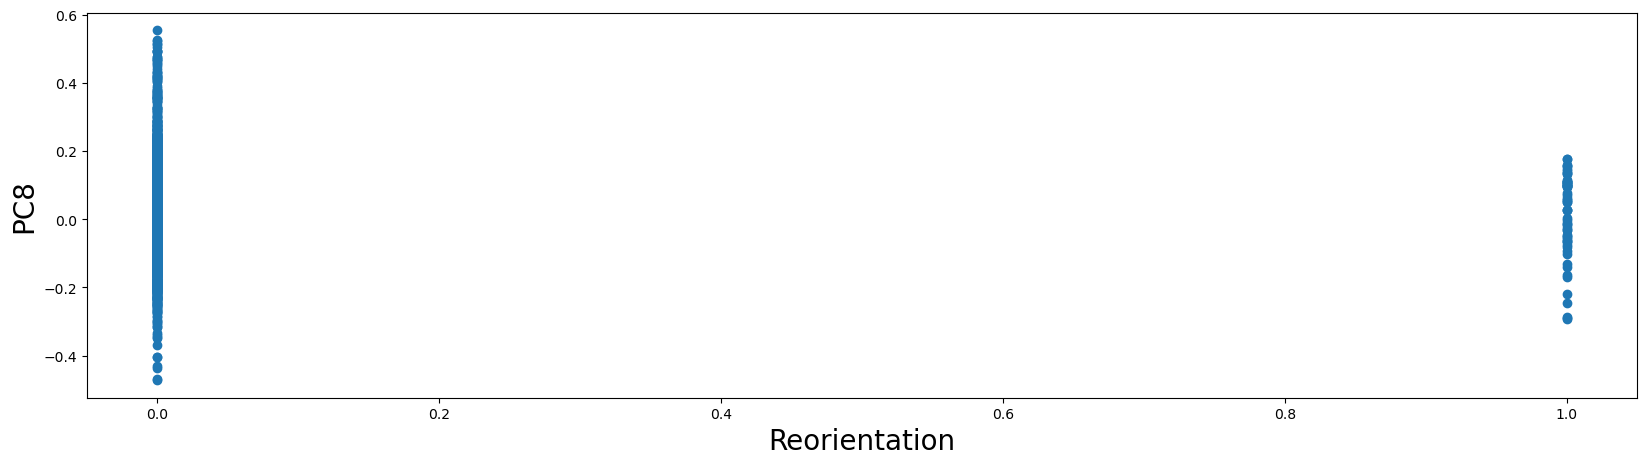

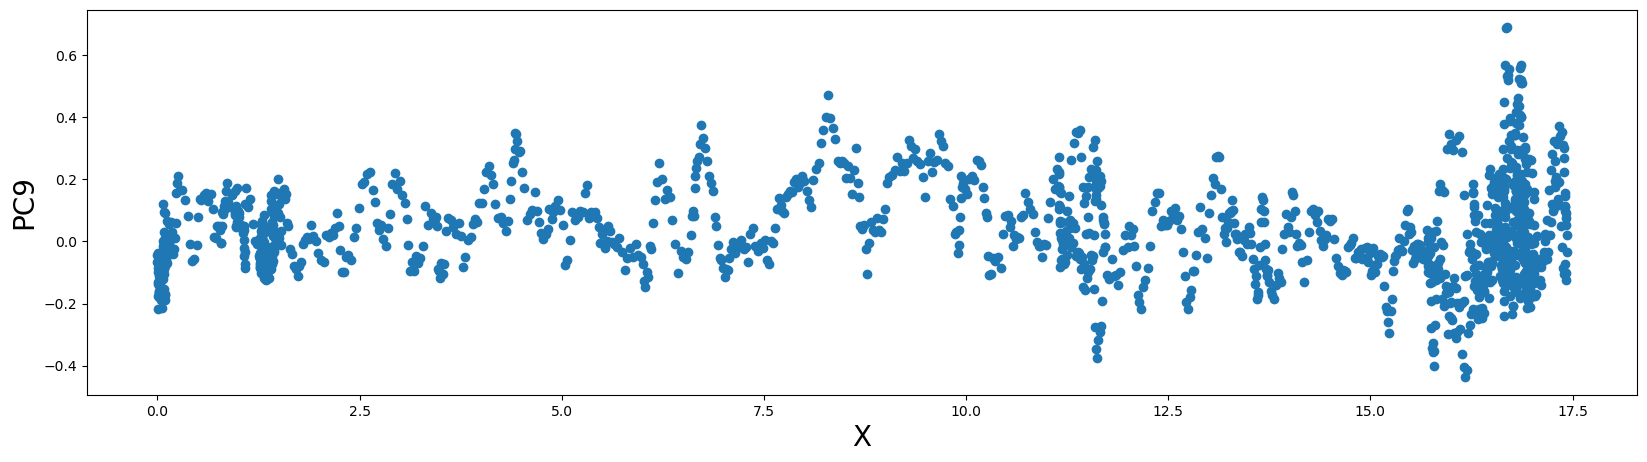

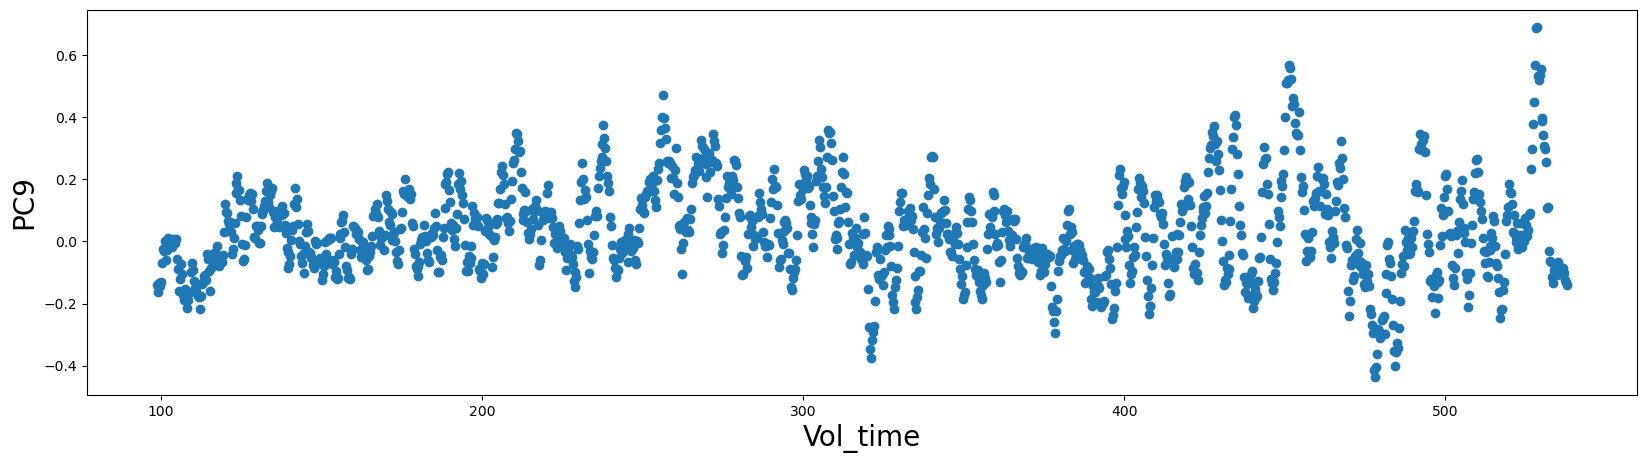

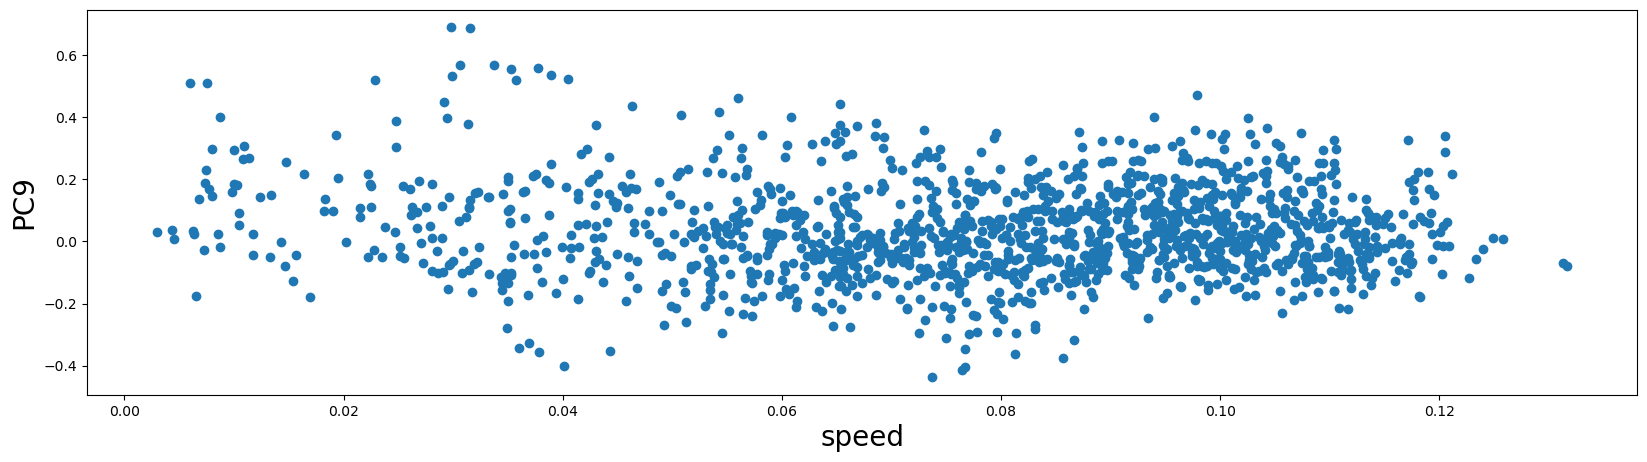

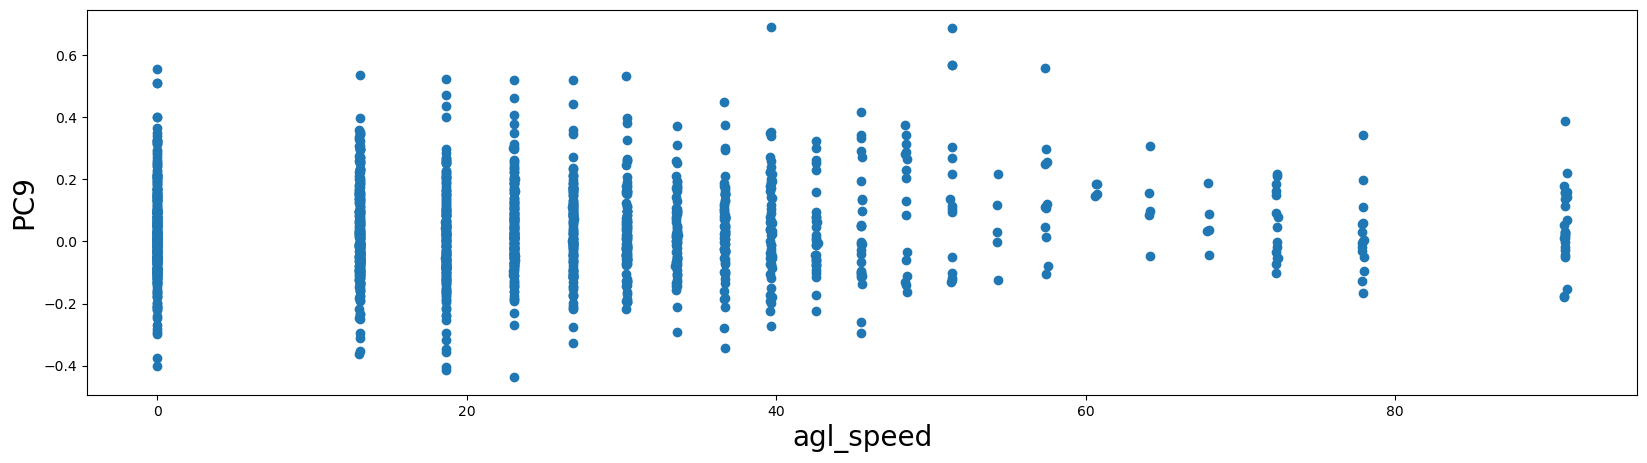

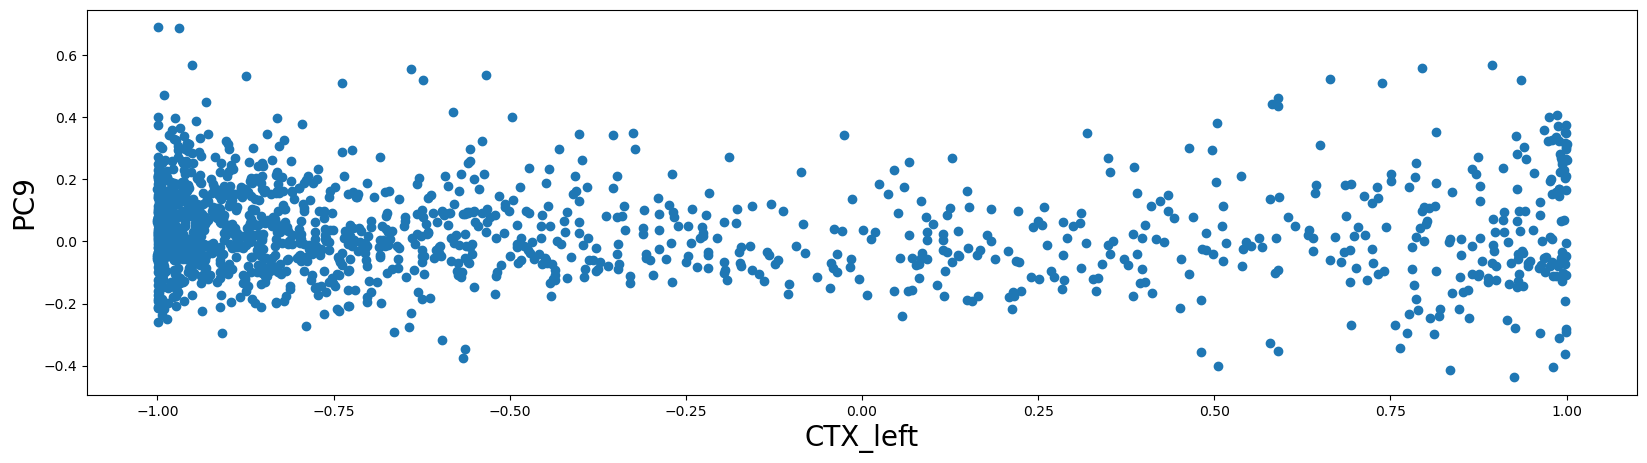

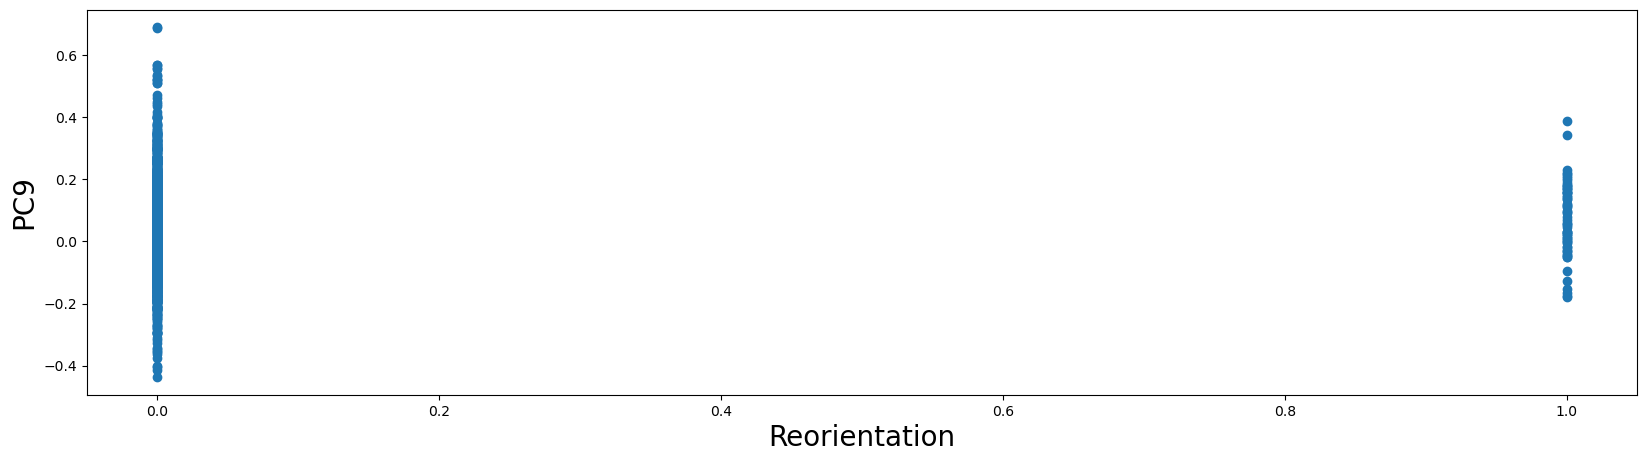

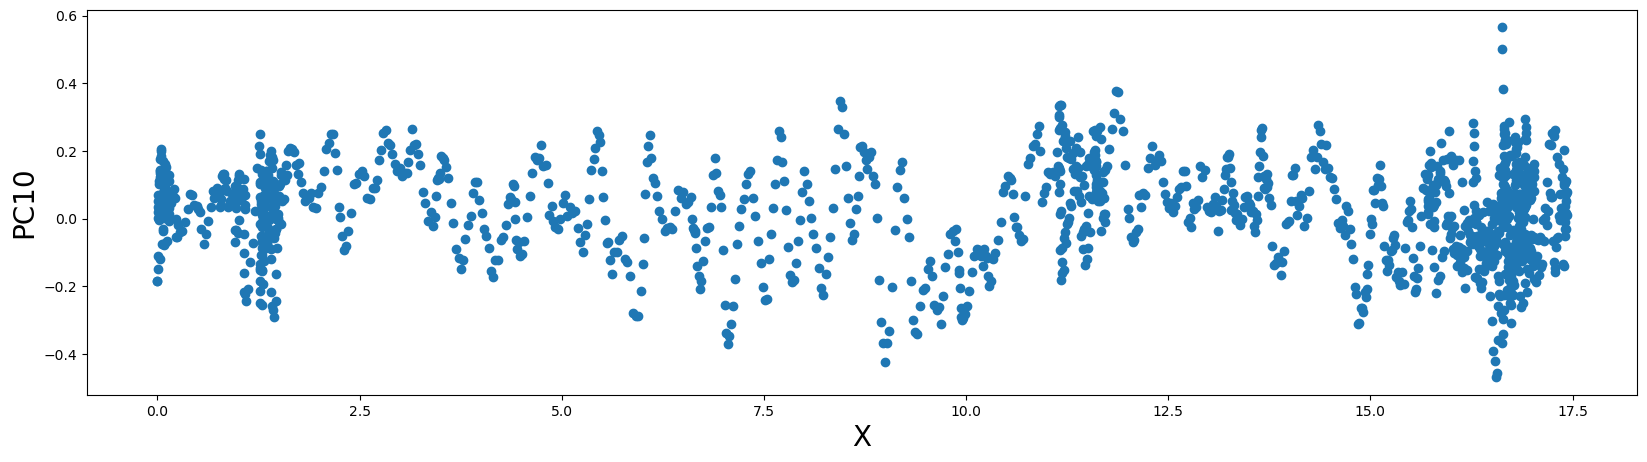

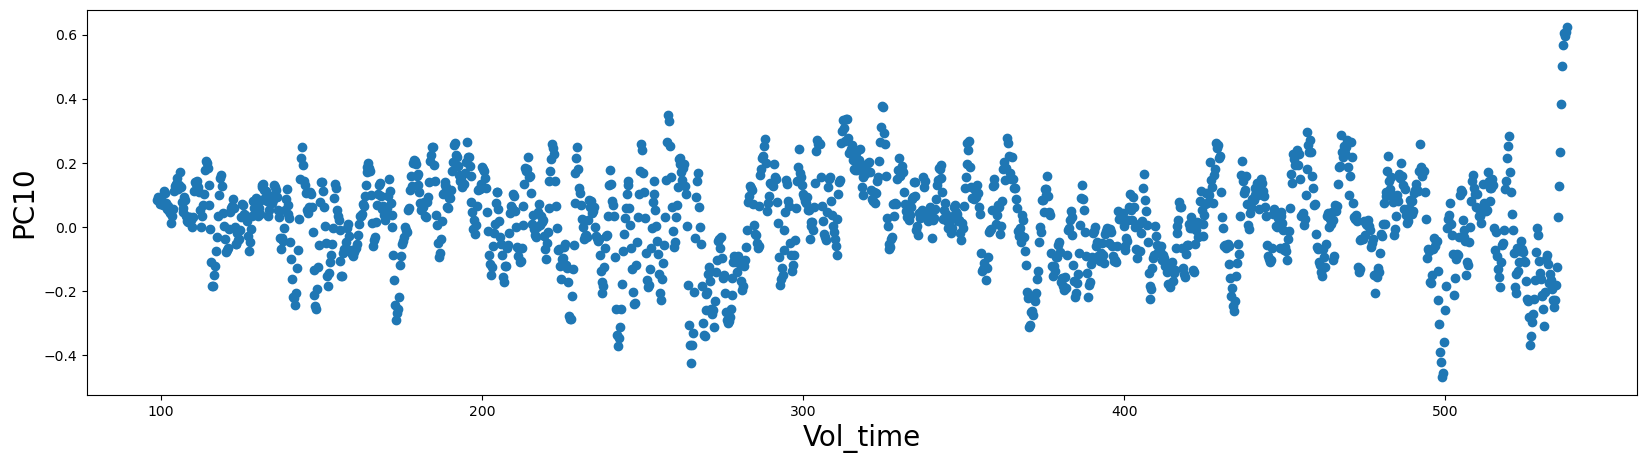

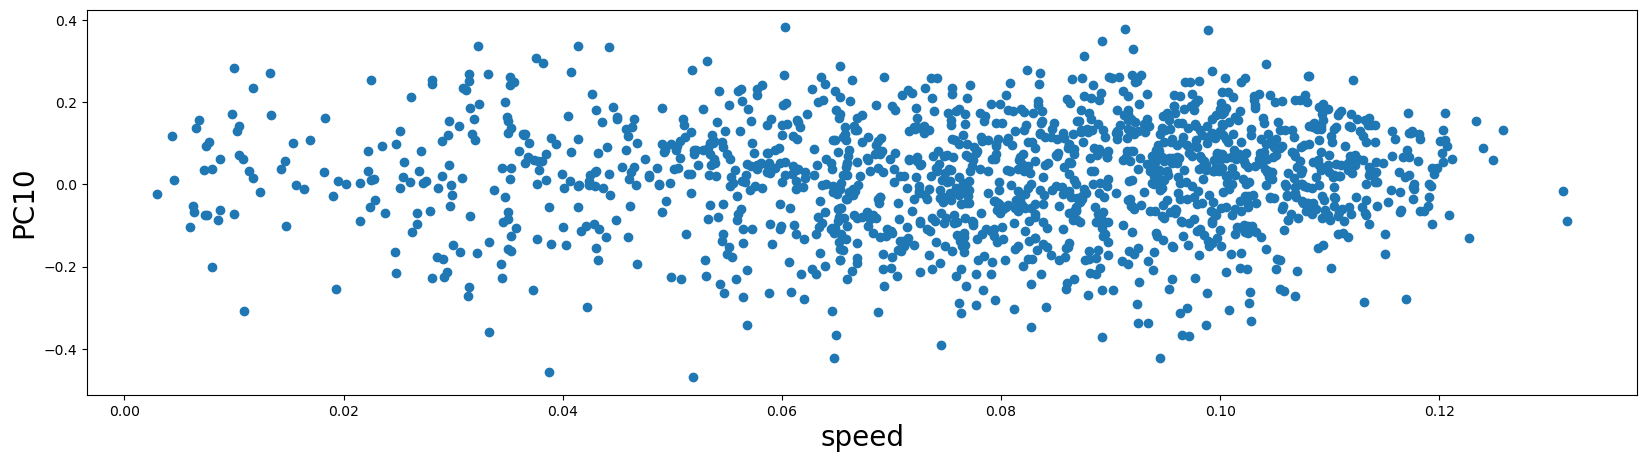

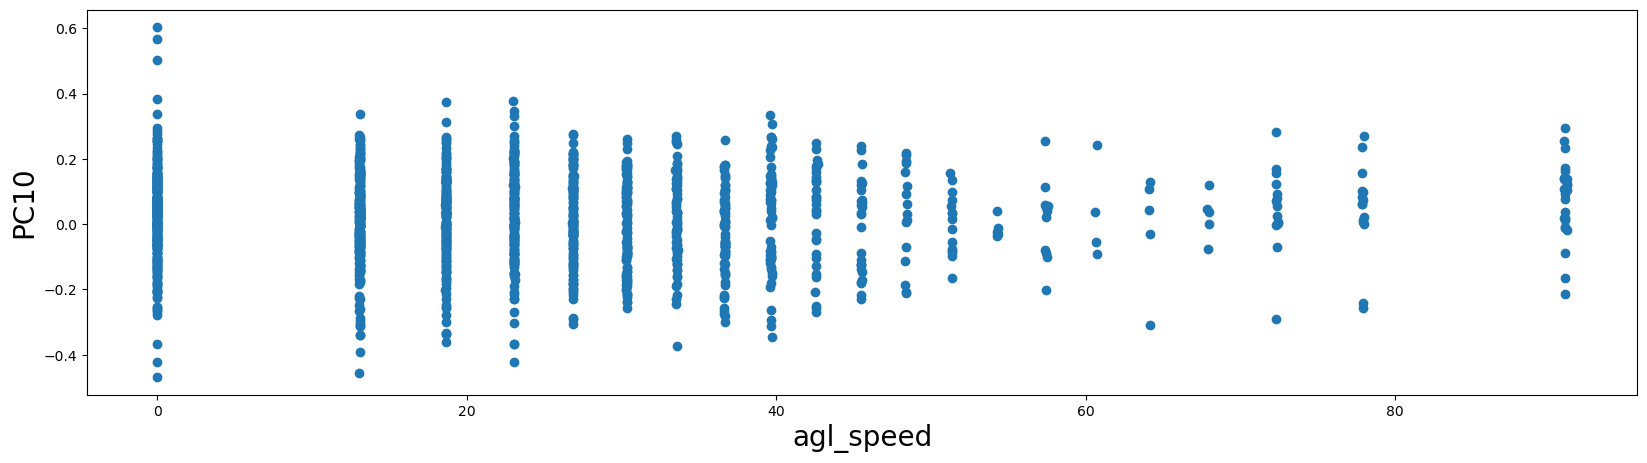

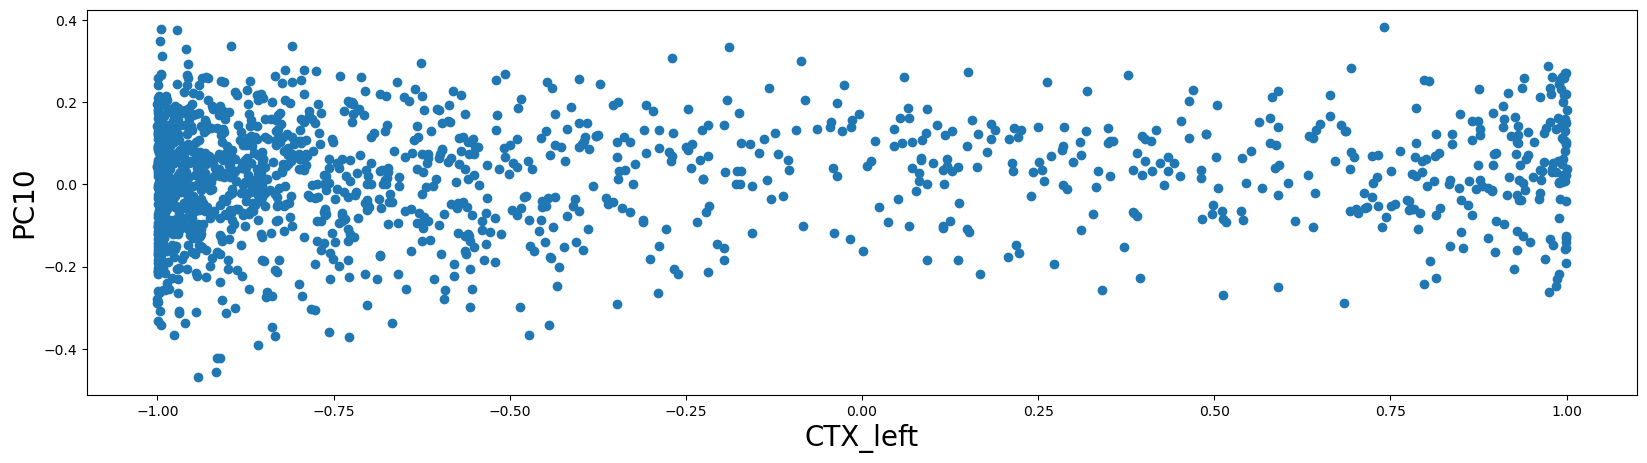

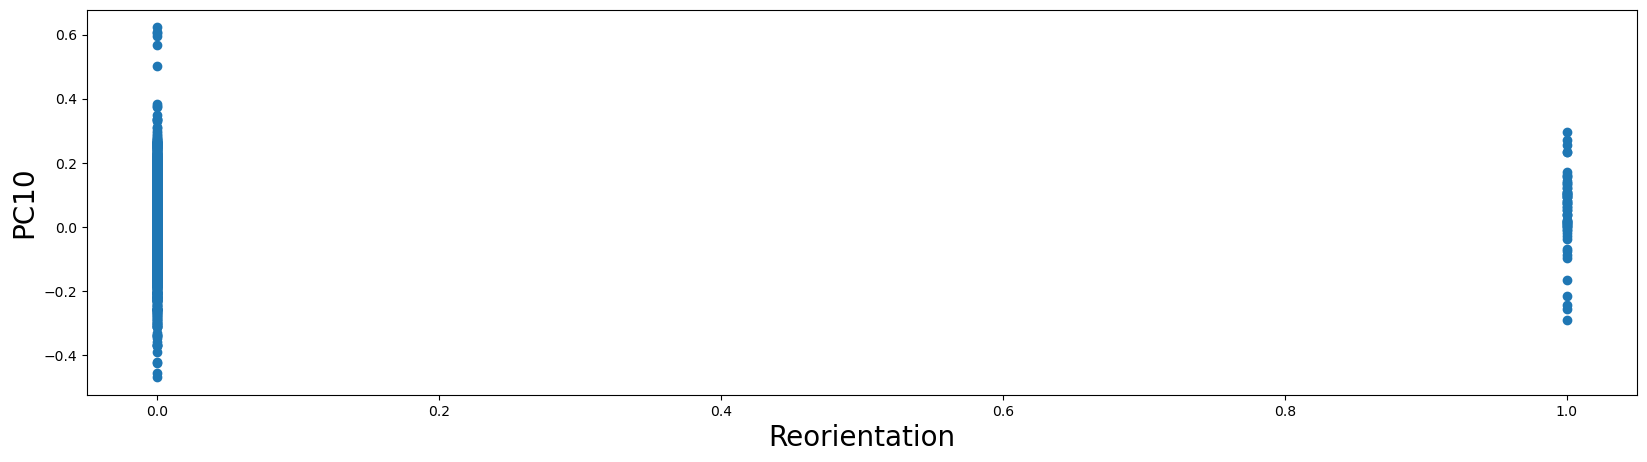

In [43]:
# 画所有PC和行为组合的相关性

fs = 20
folder = r'Z:\data space+\C. elegans chemotaxis\20241223_WBI\121906fig'
pc_cols = ['PC1', 'PC2', 'PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10']
x_cols = ['X','Vol_time', 'speed', 'agl_speed','CTX_left','Reorientation']
for i,pc in enumerate(pc_cols):
    for j, x_col in enumerate(x_cols):
        plt.figure(figsize = (20,5))
        plt.scatter(df_nt_mx[x_col], df_nt_mx[pc])
        plt.xlabel(x_col, fontsize = fs)
        plt.ylabel(pc, fontsize = fs)
        filename = pc+'-'+x_col
        plt.savefig(os.path.join(folder,filename))

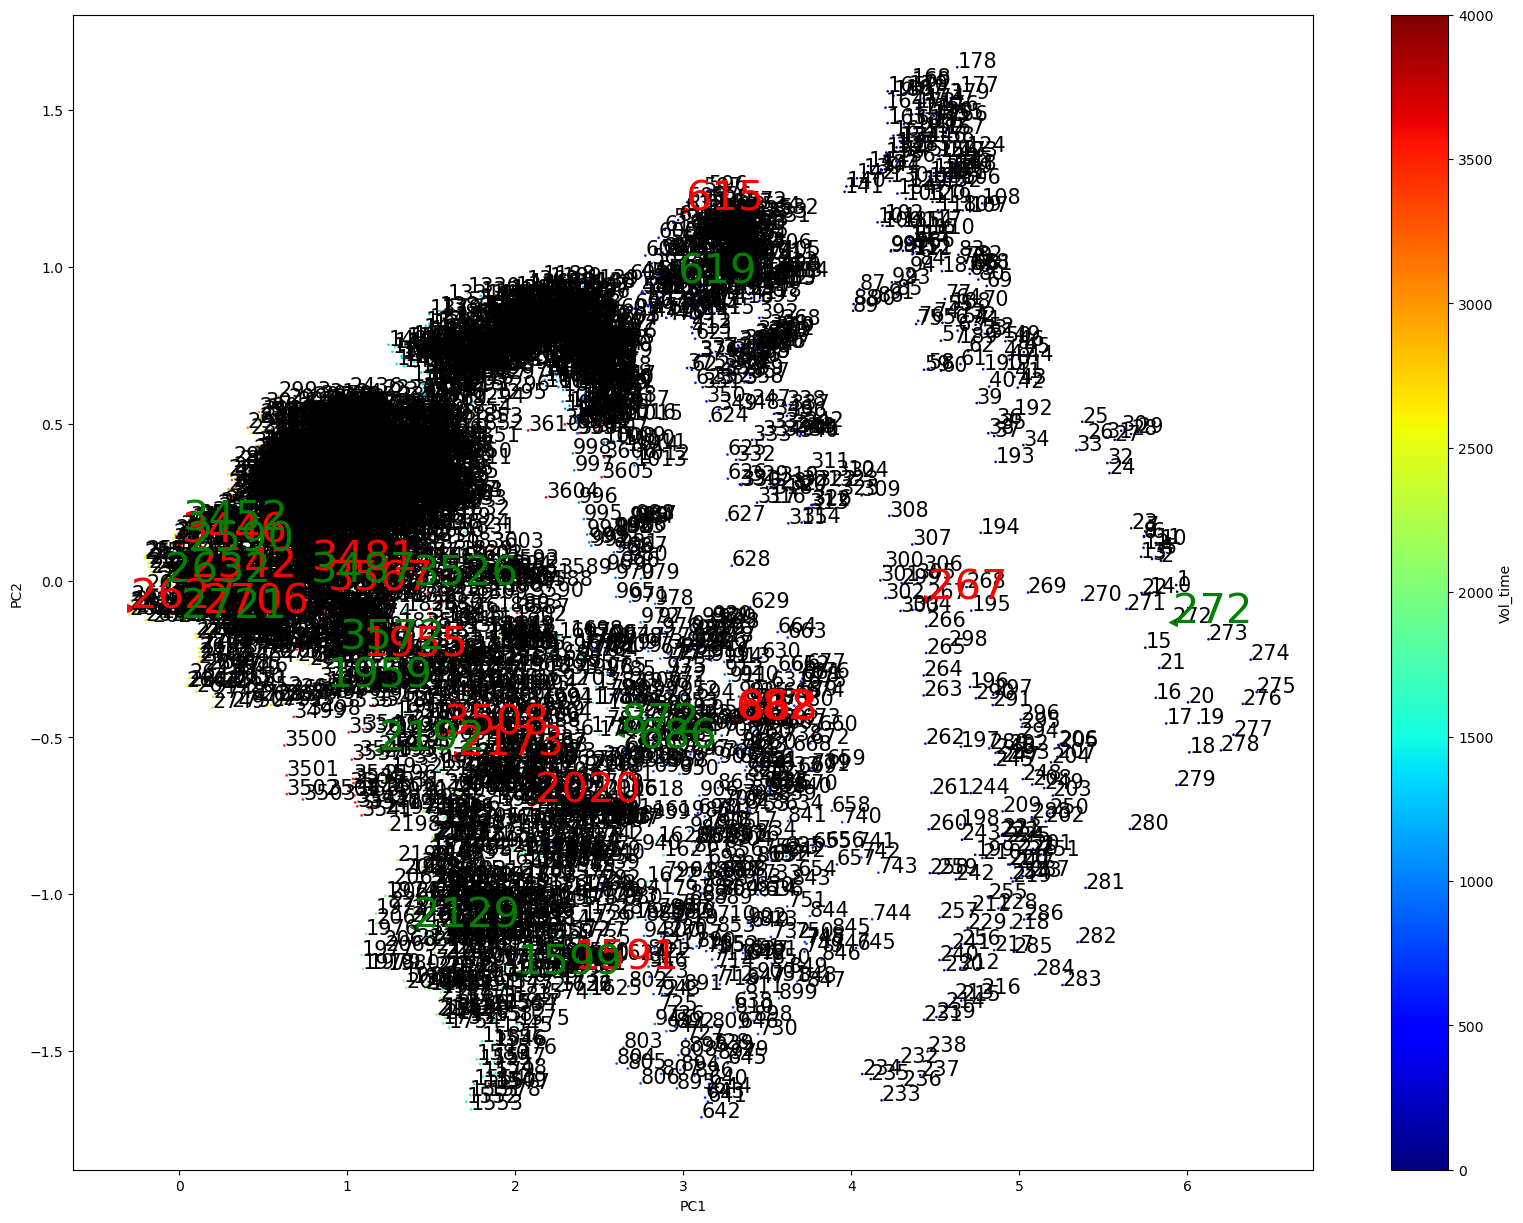

In [317]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable

fig, ax = plt.subplots(figsize = (20,15))
fs = 30
label = 'Vol_time'
# 绘制散点图，并返回散点图对象
sc = ax.scatter(df_nt_mx['PC1'], df_nt_mx['PC2'], c=df_nt_mx.index,cmap='jet', s=0.8)
df_nt_start = df_nt_mx.loc[start_indices]

ls_all_idx = list(df_nt_mx.index)
str_all_ls_idx = list(map(str,ls_all_idx))

for x, y, text in zip(df_nt_mx['PC1'], df_nt_mx['PC2'], str_all_ls_idx):
    plt.text(x, y, text, color='k', fontsize=fs*0.5)

df_nt_end = df_nt_mx.loc[end_indices]
ls_s_idx = list(df_nt_start.index)
str_s_ls_idx = list(map(str,ls_s_idx))
for x, y, text in zip(df_nt_start['PC1'], df_nt_start['PC2'], str_s_ls_idx):
    plt.text(x, y, text, color='r', fontsize=fs)

ls_e_idx = list(df_nt_end.index)
str_e_ls_idx = list(map(str,ls_e_idx))
for x, y, text in zip(df_nt_end['PC1'], df_nt_end['PC2'], str_e_ls_idx):
    plt.text(x, y, text, color='g', fontsize=fs)    

start = ax.scatter(df_nt_start['PC1'], df_nt_start['PC2'], s=fs, marker='>', c = 'r')
end = ax.scatter(df_nt_end['PC1'], df_nt_end['PC2'], s=fs, marker='<', c = 'g')
# sm = ScalarMappable(cmap=cmp, norm=plt.Normalize(vmin=df_nt.X.max(), vmax=df_nt.X.min()))
# sm.set_array([])  # 需要设置数组，即使它是空的

# 添加颜色条，并设置标签
plt.colorbar(sc, label=label)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


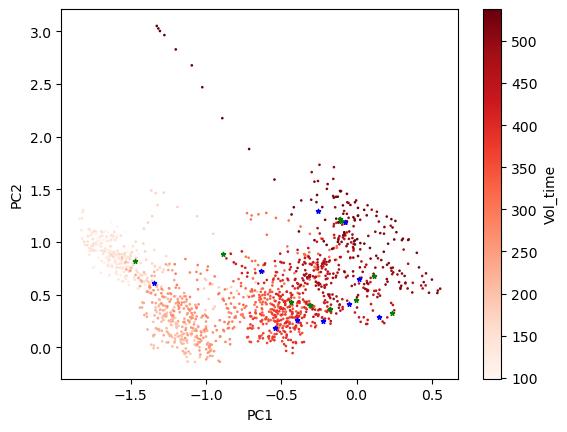

In [80]:

fig, ax = plt.subplots()
label = 'Vol_time'
# 绘制散点图，并返回散点图对象
sc = ax.scatter(df_nt_mx['PC1'], df_nt_mx['PC2'], c=df_nt_mx[label],cmap='Reds', s=0.8)
df_nt_start = df_nt_mx.loc[start_indices]
df_nt_end = df_nt_mx.loc[end_indices]
start = ax.scatter(df_nt_start['PC1'], df_nt_start['PC2'], s=10, marker='*', c = 'b')
end = ax.scatter(df_nt_end['PC1'], df_nt_end['PC2'], s=10, marker='*', c = 'g')
# sm = ScalarMappable(cmap=cmp, norm=plt.Normalize(vmin=df_nt.X.max(), vmax=df_nt.X.min()))
# sm.set_array([])  # 需要设置数组，即使它是空的

# 添加颜色条，并设置标签
plt.colorbar(sc, label=label)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [181]:
import matplotlib.colors as mcolors
# PC可视化
# pos_col = 'CTX_left'
nt_col = 'CTX_left'
x_label = pos_col
fs = 25
start = 3000
end=4000
df_nt_t = df_nt.loc[start:end,:]
# 可视化 PC1，颜色根据归一化 'X' 值设置
plt.figure(figsize=(15, 10), dpi=1000)
scatter = plt.scatter(df_nt_t.X, df_nt_t.Y,c = df_nt_t[nt_col], cmap='jet', s=2)
bar = plt.colorbar(scatter)  # 添加 colorbar 和标签
bar.ax.tick_params(labelsize=fs*0.5)
bar.set_label(label=nt_col, fontsize=fs*0.75)
plt.title(f'Trajectory label with{nt_col}from{start}to{end} ', fontsize=fs, pad = 20)
plt.xticks(fontsize=fs*0.5)
plt.yticks(fontsize=fs*0.5)
plt.xlabel('X(mm)', fontsize=fs*0.85)
ax = plt.gca()
ax.set_aspect(1)
plt.ylabel('Y(mm)', fontsize=fs*0.85)
plt.grid(True, linestyle='dashed', alpha=0.5)
plt.show()

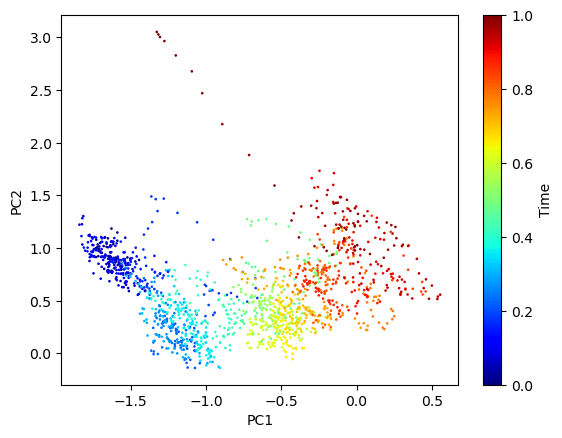

In [200]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable
# colors = np.linspace(0, 1, 4001)
# cmap = ListedColormap(['red', 'blue'])
cmp=plt.get_cmap('jet') 
lin=np.linspace(0, 1, calcium_intensity.shape[1])
colors=cmp(lin)
t=calcium_intensity.shape[1]

fig, ax = plt.subplots()

# 绘制散点图，并返回散点图对象
sc = ax.scatter(xn[:t, 0], xn[:t, 1], c=colors[:t], s=0.8)
sm = ScalarMappable(cmap=cmp, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])  # 需要设置数组，即使它是空的

# 添加颜色条，并设置标签
cbar = fig.colorbar(sm, ax=ax, label='Time')
plt.xlabel('PC1')
plt.ylabel('PC2')
# cbar.set_ticks(np.linspace(0, 1, 20))  # 设置颜色条的刻度
# cbar.set_ticklabels(np.linspace(0, 1, 20)) 
# plt.colorbar(ax.collections[0],label='Time')
# plt.savefig(f'{save_p}/2d_pca.png')
plt.show()


Text(0, 0.5, 'PC1')

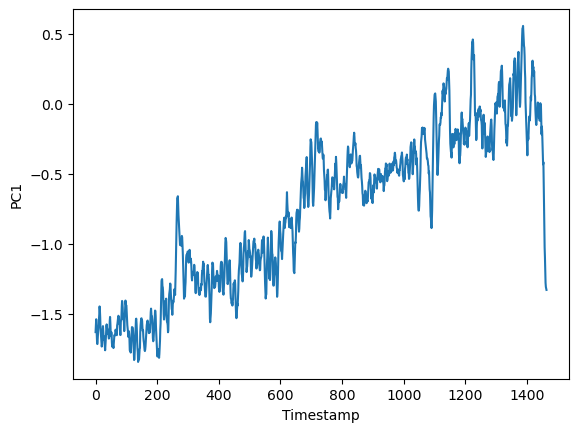

In [205]:
plt.plot(xn[:t,0])
plt.xlabel('Timestamp')
plt.ylabel('PC1')

Text(0.5, 0, 'PC3')

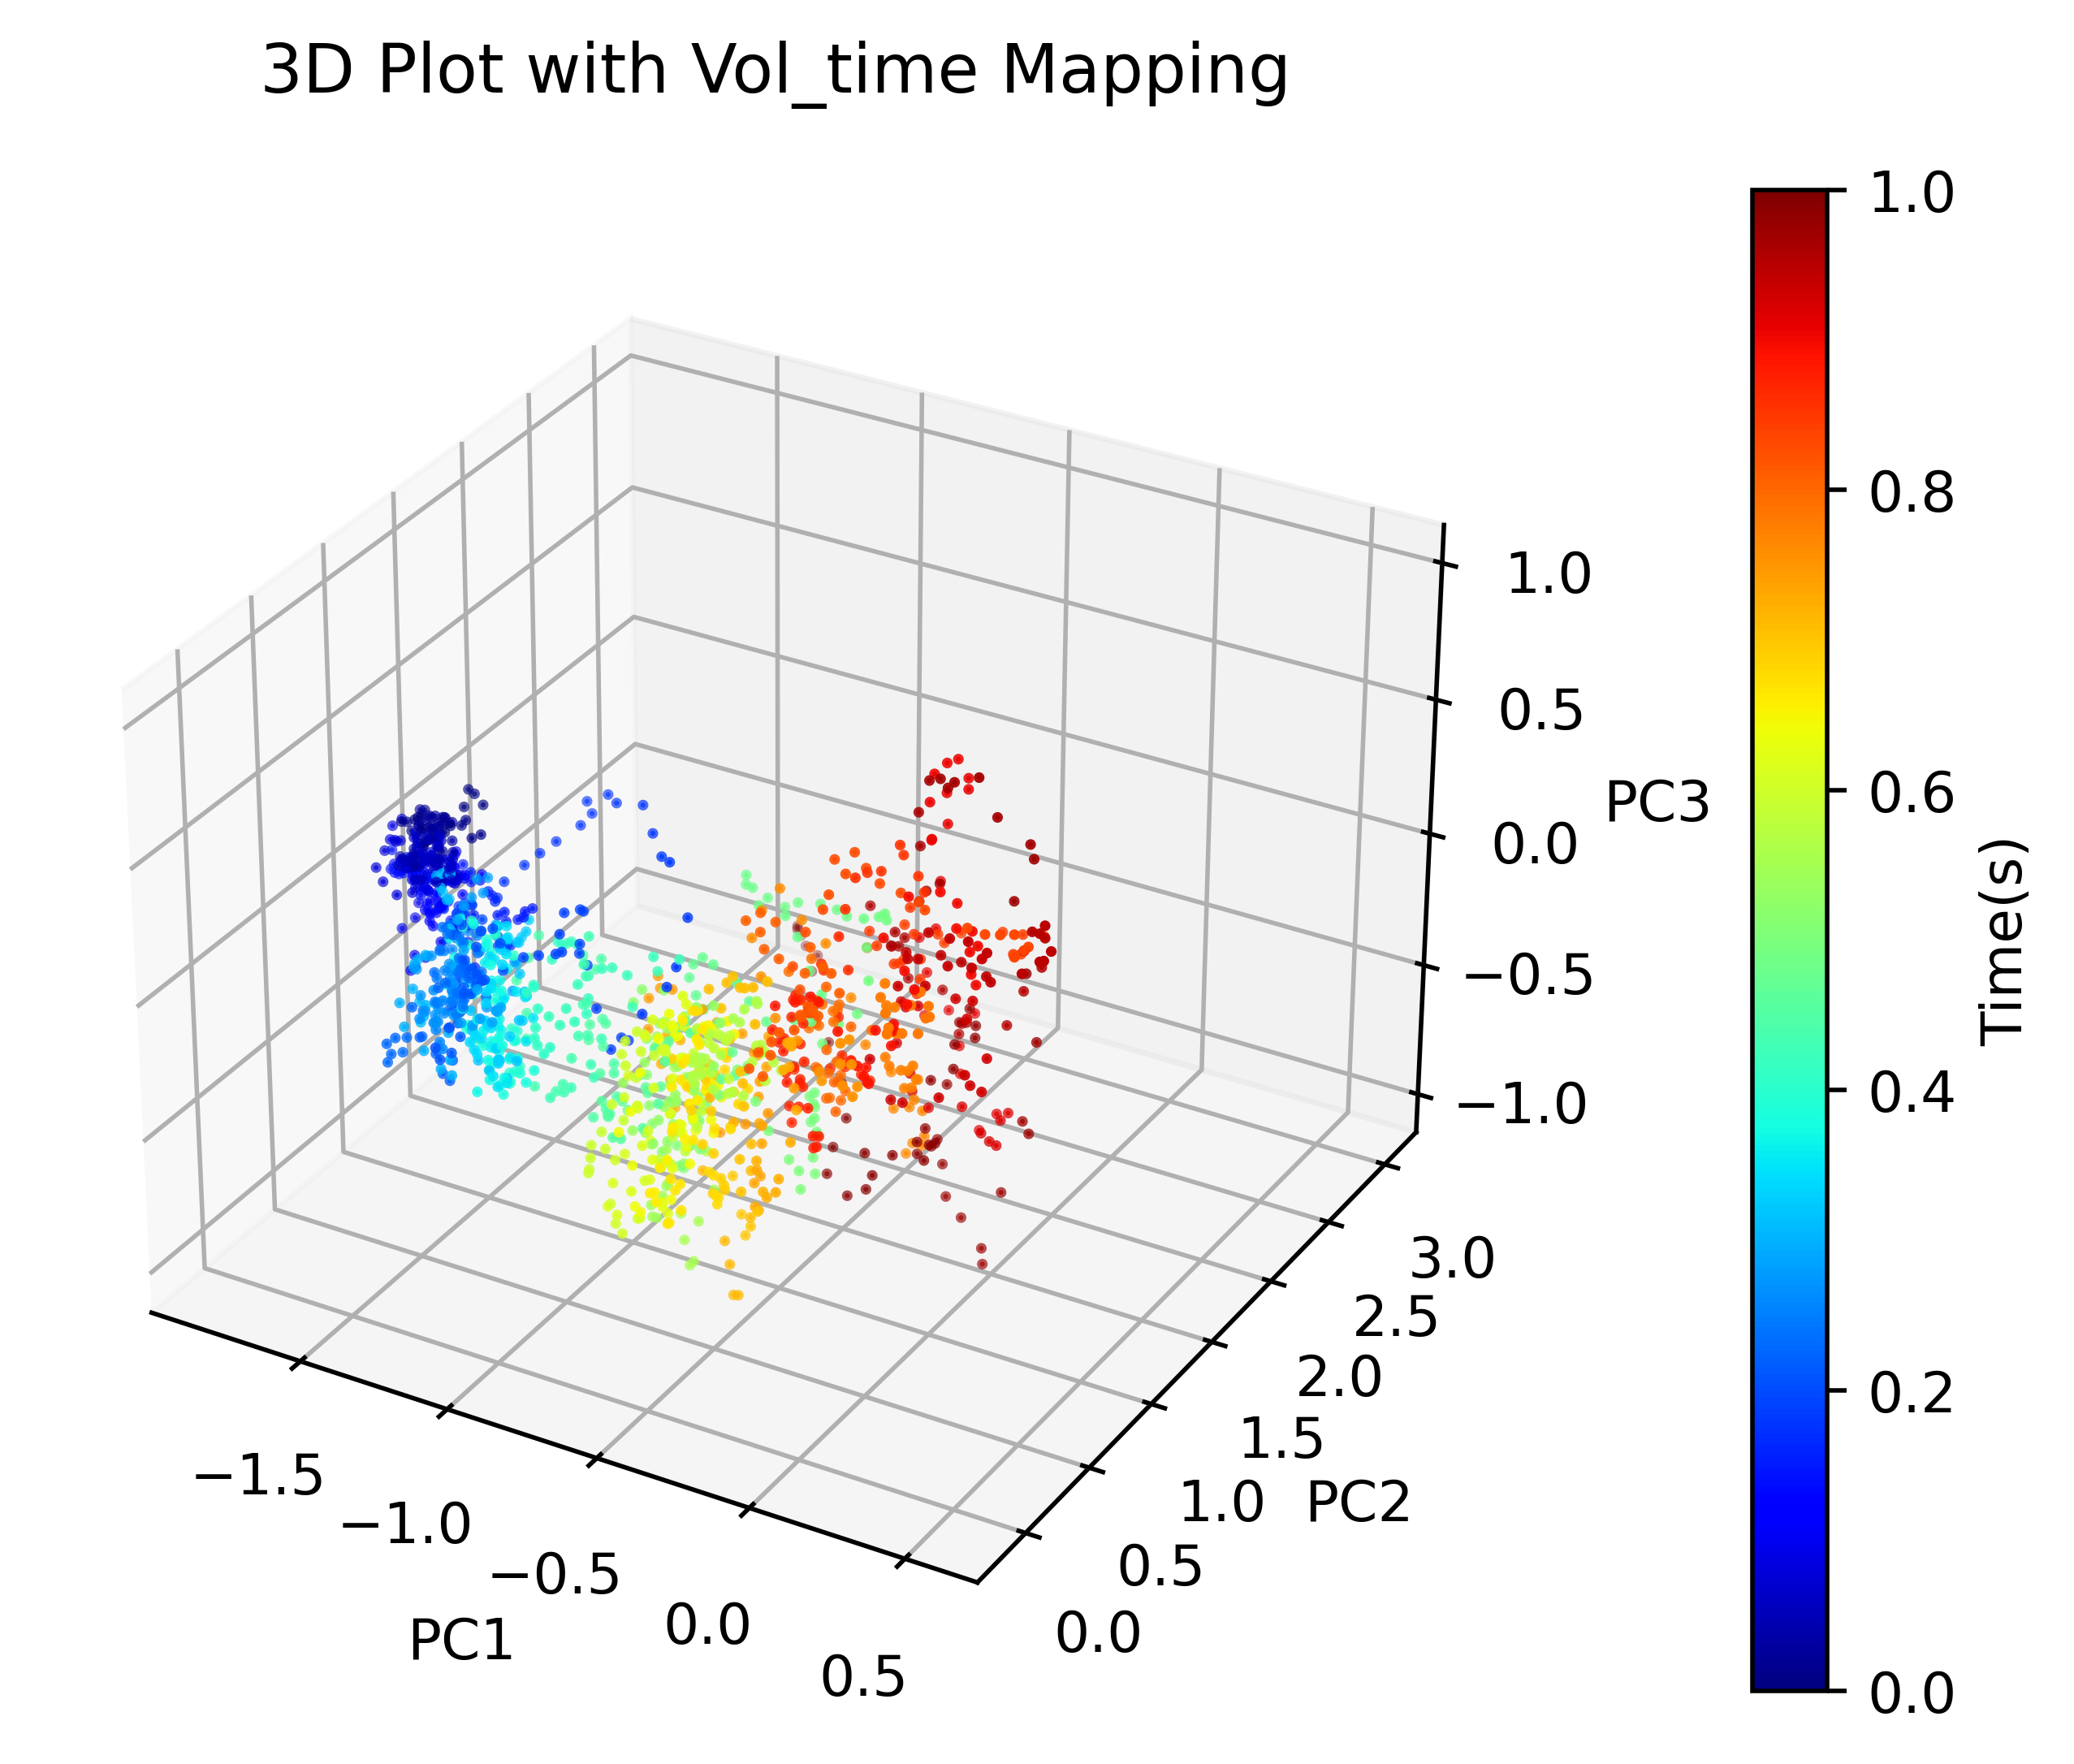

In [208]:
from mpl_toolkits.mplot3d import Axes3D

col = 'Vol_time'
x = xn[:t, 0]
y = xn[:t, 1]
z = xn[:t, 2]
color_values = lin[:t]  # 获取对应的颜色值

# 绘图
fig = plt.figure(dpi=500)
ax = fig.add_subplot(projection='3d')

# 使用 scatter 绘制带颜色的 3D 点
scatter = ax.scatter(x, y, z, c=color_values, cmap='jet', marker='o', s=0.8)

# 添加 colorbar
cbar = plt.colorbar(scatter, ax=ax, pad = 0.12)
cbar.set_label('Time(s)')

# 设置标题和标签
ax.set_title(f'3D Plot with {col} Mapping', pad=20)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')